In [1]:
import torch
print("Using torch", torch.__version__)

Using torch 2.0.1+cu117


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split    # For splitting the dataset
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay  # For plotting the non liner decision boundaries
from sklearn.model_selection import GridSearchCV        # For hyperperameter tuning
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

## Data Pre-processing

In [4]:
training_data_95 = pd.read_csv('../csvs/hog_95/extracted_features_hog_95.csv',header = None)
print(training_data_95)

# X_train_df = training_data_95.drop(columns = [0])
# y_train_df = training_data_95[0]

# print(X_train_df)
# print(y_train_df)

                    0         1         2         3         4         5     \
0      Rachel_Leigh_Cook  0.101289  1.330157 -0.964354  0.278769 -0.543510   
1          Roseanne_Barr  0.391125  0.704784  1.217563 -0.780129 -1.414380   
2         Vladimir_Putin -1.246895 -0.680080  0.591671 -2.354134 -1.920589   
3           Carlos_Menem  0.597257 -0.661087  1.356273 -0.878202 -0.588220   
4          Lynne_Thigpen -1.589231 -0.049223 -1.306154 -0.461846  0.250779   
...                  ...       ...       ...       ...       ...       ...   
10581    Rohinton_Mistry  1.724274 -1.189989 -1.052075  1.067114 -0.041331   
10582      George_W_Bush  2.658667  0.404976  0.808148 -0.520925 -0.804796   
10583        Vicente_Fox  0.479659 -0.820659  0.506519  0.026553  1.815414   
10584          Todd_Wike -1.765033 -0.231035  0.285658 -1.902368 -0.086056   
10585         Kofi_Annan  1.083461  0.993570 -0.346959  1.194149 -1.330585   

           6         7         8         9     ...  3239   3240

In [5]:
testing_data_95 = pd.read_csv('../csvs/hog_95/extracted_features_test_hog_95.csv', header = None)
print(testing_data_95)

# X_test_df = testing_data_95.drop(columns = [0])
# y_test_df = testing_data_95[0]

# print(X_test_df)
# print(y_test_df)

                         0         1         2         3         4     \
0              Carolina_Kluft  1.943908 -0.685770  0.135847 -0.574862   
1            Roger_Etchegaray -1.104129  0.259980 -1.581375  0.471127   
2                  JK_Rowling  1.170456 -1.014306 -0.396331  0.125549   
3     Valery_Giscard_dEstaing  1.449810  0.777844  1.786893 -0.590618   
4         Juan_Carlos_Ferrero -0.364156 -1.960419 -0.170895  0.499791   
...                       ...       ...       ...       ...       ...   
2642            Michael_Chang  1.412572 -0.760504  0.483098 -0.281977   
2643              Osrat_Iosef  1.675409  2.553274 -0.504704 -0.422554   
2644              Yann_Martel  1.023609 -0.542472  0.853466  0.449747   
2645             Mitzi_Gaynor -0.901391  0.372586  2.181821  0.809191   
2646                Fujio_Cho  0.938650 -0.126036 -1.422143  0.285539   

          5         6         7         8         9     ...  3239   3240  \
0    -0.959423  0.472946  0.260016  0.167261 -0

### Taking only the images of persons whose number of images are greater than equal to 70

In [6]:
df = pd.concat([training_data_95,testing_data_95],axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13233 entries, 0 to 2646
Columns: 3249 entries, 0 to 3248
dtypes: float64(3248), object(1)
memory usage: 328.1+ MB


In [7]:
df_70 = df[df[0].map(df[0].value_counts()) >= 70]  # Reference Stack overflow
df_70.reset_index(drop=True, inplace = True)
df_70

,0,1,2,3,4,5,6,7,8,9,...,3239,3240,3241,3242,3243,3244,3245,3246,3247,3248
0,George_W_Bush,-1.824086,-0.401801,-0.521794,-0.587088,-0.509684,0.280968,-1.599484,0.290741,0.713462,...,31.0,359.0,1280.0,349.0,26.0,262.0,456.0,332.0,313.0,16523.0
1,Colin_Powell,0.549831,-0.715630,1.769869,0.222841,0.108078,0.219034,-0.818753,-0.839518,-0.129442,...,44.0,504.0,1817.0,748.0,30.0,501.0,556.0,396.0,362.0,14746.0
2,George_W_Bush,-0.628315,-0.750331,0.547397,0.478640,2.337426,0.526050,0.712348,-1.843158,-0.076518,...,27.0,302.0,1903.0,347.0,13.0,263.0,381.0,313.0,252.0,29224.0
3,George_W_Bush,2.176470,-0.997268,0.699885,-1.213921,0.090995,1.768202,0.787791,-0.212840,0.012334,...,58.0,725.0,2027.0,597.0,39.0,361.0,507.0,334.0,312.0,6742.0
4,Tony_Blair,-2.303506,-0.646863,0.022650,1.529321,0.472518,0.093752,0.199501,-0.097458,-0.722055,...,25.0,374.0,2097.0,485.0,12.0,340.0,622.0,450.0,491.0,16778.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,George_W_Bush,-0.754818,-0.751547,-0.307345,0.836765,-0.443559,0.034152,1.786415,0.199164,-0.641788,...,41.0,496.0,1763.0,513.0,22.0,445.0,518.0,527.0,430.0,11888.0
1284,Tony_Blair,0.356975,-0.575622,-1.112081,-0.147580,2.257156,1.439668,-0.556521,0.081855,1.255535,...,45.0,646.0,3227.0,691.0,25.0,573.0,724.0,379.0,567.0,12012.0
1285,George_W_Bush,2.378569,0.299064,-0.343518,1.097499,0.782947,0.991848,-0.635729,-0.408563,-0.150484,...,40.0,353.0,1540.0,480.0,35.0,355.0,396.0,395.0,318.0,27232.0
1286,Tony_Blair,0.732607,-0.158723,-2.044487,0.405323,1.605780,-0.532496,-0.508825,0.240685,0.907796,...,35.0,522.0,1654.0,719.0,30.0,543.0,728.0,603.0,519.0,8109.0


In [8]:
print("Number of persons are ",df_70[0].unique().shape[0])

Number of persons are  7


In [9]:
X_70 = df_70.drop(columns = [0])
y_70 = df_70[0]
X_train_70_df, X_test_70_df, y_train_70, y_test_70 = train_test_split(X_70,y_70,train_size=0.8,random_state=42)
X_train_70_df.reset_index(drop=True, inplace = True)
X_test_70_df.reset_index(drop=True, inplace = True)
y_train_70.reset_index(drop=True, inplace = True)
y_test_70.reset_index(drop=True, inplace = True)
print(X_70)

          1         2         3         4         5         6         7     \
0    -1.824086 -0.401801 -0.521794 -0.587088 -0.509684  0.280968 -1.599484   
1     0.549831 -0.715630  1.769869  0.222841  0.108078  0.219034 -0.818753   
2    -0.628315 -0.750331  0.547397  0.478640  2.337426  0.526050  0.712348   
3     2.176470 -0.997268  0.699885 -1.213921  0.090995  1.768202  0.787791   
4    -2.303506 -0.646863  0.022650  1.529321  0.472518  0.093752  0.199501   
...        ...       ...       ...       ...       ...       ...       ...   
1283 -0.754818 -0.751547 -0.307345  0.836765 -0.443559  0.034152  1.786415   
1284  0.356975 -0.575622 -1.112081 -0.147580  2.257156  1.439668 -0.556521   
1285  2.378569  0.299064 -0.343518  1.097499  0.782947  0.991848 -0.635729   
1286  0.732607 -0.158723 -2.044487  0.405323  1.605780 -0.532496 -0.508825   
1287 -0.431153 -1.341352 -0.610607 -0.411693  0.667436 -0.542481 -1.090542   

          8         9         10    ...  3239   3240    3241   

In [10]:
#Normalising the data
scaler=StandardScaler()
X_train_arr=X_train_70_df.values
X_test_arr=X_test_70_df.values
X_train_arr_n=scaler.fit_transform(X_train_arr)
joblib.dump(scaler,'Standard_Scalar_Normalisation_70.joblib')
X_test_arr_n = scaler.transform(X_test_arr)
X_train_70 = pd.DataFrame(X_train_arr_n)
X_test_70 = pd.DataFrame(X_test_arr_n)
# X_train_70

# All features concatenated

## LinearSVC

In [11]:
# Training Linear Support Vector Classifier (LinearSVC)
lin_clf = svm.LinearSVC(dual=False)
lin_clf.fit(X_train_70, y_train_70)

C:\Users\bharm\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False)

In [12]:
joblib.dump(lin_clf,'LinearSVC_All_n_70.joblib')

['LinearSVC_All_n_70.joblib']

In [13]:
pred_y_test_70 = lin_clf.predict(X_test_70)

In [14]:
# Accuracy of linearSVC model
linSVC_accuracy = lin_clf.score(X_test_70, y_test_70)
print("Accuracy of linearSVC is ",linSVC_accuracy)

Accuracy of linearSVC is  0.8837209302325582


In [15]:
# Classification Report of linearSVC model
print(classification_report(y_test_70,pred_y_test_70))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.94      0.97        17
     Colin_Powell       0.92      0.96      0.94        48
  Donald_Rumsfeld       0.83      0.79      0.81        19
    George_W_Bush       0.88      0.96      0.92       102
Gerhard_Schroeder       0.87      0.71      0.78        28
      Hugo_Chavez       0.85      0.69      0.76        16
       Tony_Blair       0.81      0.79      0.80        28

         accuracy                           0.88       258
        macro avg       0.88      0.83      0.85       258
     weighted avg       0.88      0.88      0.88       258



Text(33.081597222222214, 0.5, 'True')

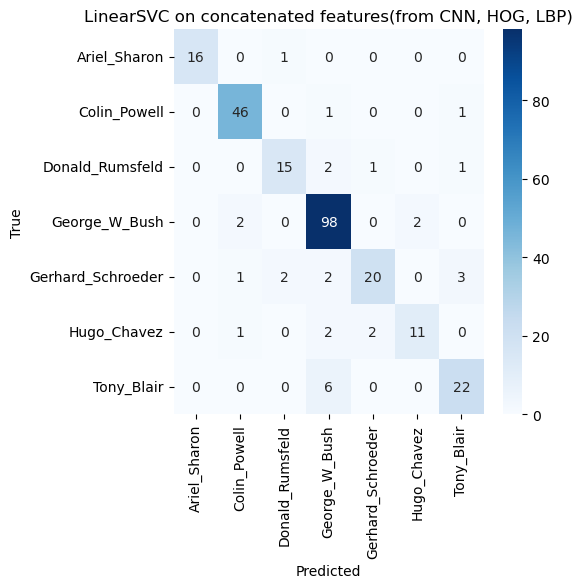

In [16]:
cm_linearSVC_ALL = confusion_matrix(y_test_70, pred_y_test_70)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_linearSVC_ALL, annot=True, fmt="d", cmap="Blues", xticklabels=lin_clf.classes_, yticklabels=lin_clf.classes_, ax=axes)
axes.set_title('LinearSVC on concatenated features(from CNN, HOG, LBP)')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

## SVM Models with Linear, polynomial and rbf kernals

In [17]:
svm_linear = SVC(kernel='linear') # linear kernal
svm_poly = SVC(kernel='poly', degree= 3)  # Polynomial kernel of degree 3
svm_rbf = SVC(kernel='rbf')  # RBF kernel

In [18]:
svm_linear.fit(X_train_70, y_train_70)
svm_poly.fit(X_train_70, y_train_70)
svm_rbf.fit(X_train_70, y_train_70)

SVC()

In [19]:
joblib.dump(svm_linear,'svm_linear_ALL_n_70.joblib')
joblib.dump(svm_poly,'svm_poly_ALL_n_70.joblib')
joblib.dump(svm_rbf,'svm_rbf_ALL_n_70.joblib')

['svm_rbf_ALL_n_70.joblib']

### Linear Kernel

In [20]:
svm_linear.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [21]:
lin_pred_y_70 = svm_linear.predict(X_test_70)

In [22]:
lin_accuracy = accuracy_score(y_test_70,lin_pred_y_70)
print("Accuracy of SVM with Linear kernel is ",lin_accuracy)

Accuracy of SVM with Linear kernel is  0.8488372093023255


In [23]:
print(classification_report(y_test_70,lin_pred_y_70))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.88      0.94        17
     Colin_Powell       0.92      0.94      0.93        48
  Donald_Rumsfeld       0.93      0.74      0.82        19
    George_W_Bush       0.76      0.98      0.85       102
Gerhard_Schroeder       1.00      0.50      0.67        28
      Hugo_Chavez       0.92      0.69      0.79        16
       Tony_Blair       0.95      0.71      0.82        28

         accuracy                           0.85       258
        macro avg       0.93      0.78      0.83       258
     weighted avg       0.87      0.85      0.84       258



#### Tunning Hyperparameter

In [24]:
c_values = [0.1, 1, 10, 100]

accuracy_values = []
predicted_values = []

for i in c_values:
    svm_lin_tunned = SVC(kernel='linear', C = i )
    svm_lin_tunned.fit(X_train_70, y_train_70)
    lin_t_pred_y_70 = svm_lin_tunned.predict(X_test_70)
    lin_t_accuracy = accuracy_score(y_test_70,lin_t_pred_y_70)
    
    accuracy_values.append(lin_t_accuracy)
    predicted_values.append(lin_t_pred_y_70)
    
print(accuracy_values)

[0.8488372093023255, 0.8488372093023255, 0.8488372093023255, 0.8488372093023255]


Therefor, value of c (between 0.1 to 100) is not affecting the accuracy.
So, no requirement of hyperparameter tuning.

### Polynomial Kernel

In [25]:
svm_poly.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [26]:
poly_pred_y_70 = svm_poly.predict(X_test_70)

In [27]:
poly_accuracy = accuracy_score(y_test_70,poly_pred_y_70)
print("Accuracy of SVM with polynomial kernel (of degree 3) is ",poly_accuracy)

Accuracy of SVM with polynomial kernel (of degree 3) is  0.3953488372093023


In [28]:
print(classification_report(y_test_70,poly_pred_y_70))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        17
     Colin_Powell       0.00      0.00      0.00        48
  Donald_Rumsfeld       0.00      0.00      0.00        19
    George_W_Bush       0.40      1.00      0.57       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.00      0.00      0.00        28

         accuracy                           0.40       258
        macro avg       0.06      0.14      0.08       258
     weighted avg       0.16      0.40      0.22       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

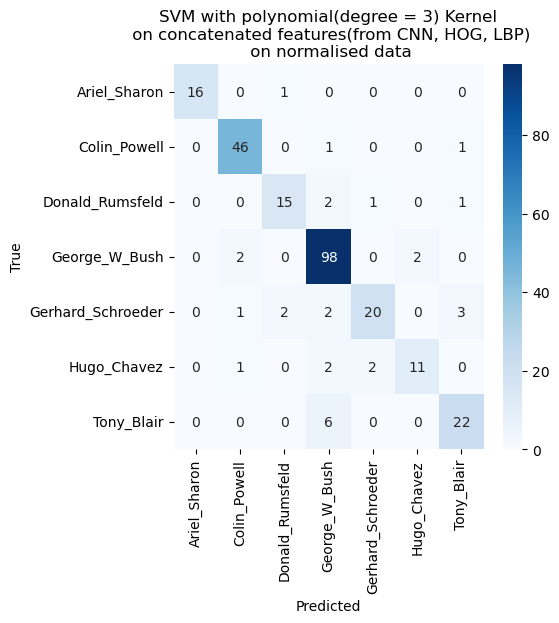

In [29]:
cm_svm_poly_ALL_n = confusion_matrix(y_test_70, pred_y_test_70)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_ALL_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly.classes_, yticklabels=svm_poly.classes_, ax=axes)
axes.set_title('SVM with polynomial(degree = 3) Kernel\n on concatenated features(from CNN, HOG, LBP)\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

#### Tuning Hyperparameters

In [30]:
# Defining parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search = GridSearchCV(estimator=svm_poly, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_70,y_train_70)

cv_results = grid_search.cv_results_
print(cv_results)
# Best parameters
poly_best_params_initial = grid_search.best_params_
poly_best_params_initial

{'mean_fit_time': array([11.76407986, 12.55448427, 12.1387763 , 11.63015566, 11.58450751,
       11.80621815, 12.0812417 , 11.522505  , 11.76207504, 12.01319509,
       11.95795364, 11.68717709, 12.17625985, 12.33322091, 12.79670248,
       11.47300053]), 'std_fit_time': array([0.4945006 , 0.47004356, 0.51350456, 0.70350959, 0.7778551 ,
       0.77284844, 0.63184988, 0.53034037, 0.56710627, 0.61968376,
       0.75705168, 0.54312134, 0.61680804, 0.74398815, 0.36914001,
       0.56491931]), 'mean_score_time': array([1.46578708, 1.48423839, 1.45667019, 1.49637284, 1.48269677,
       1.47279906, 1.48666763, 1.49367628, 1.4622963 , 1.52391481,
       1.6072154 , 1.59091854, 1.59377451, 1.43868814, 1.00886564,
       0.77419171]), 'std_score_time': array([0.03445894, 0.01268281, 0.0243993 , 0.00947392, 0.01641593,
       0.02200245, 0.02253659, 0.01829983, 0.0199756 , 0.06933997,
       0.01683587, 0.02976147, 0.03093936, 0.14605639, 0.17717217,
       0.48830945]), 'param_C': masked_array(d

{'C': 0.1, 'gamma': 0.01}

In [31]:
# cv_results['param_C'].data

In [32]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + cv_results['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + cv_results['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)

[0.41796116504854364, 0.41844660194174754, 0.41844660194174754, 0.41844660194174754]
[0.104126213592233, 0.10461165048543689, 0.10461165048543689, 0.10461165048543689]


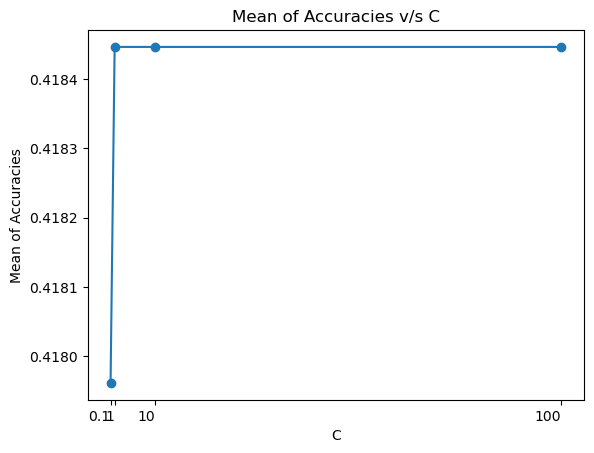

In [33]:
fig, ax = plt.subplots()


ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

# Show the plot
plt.show()

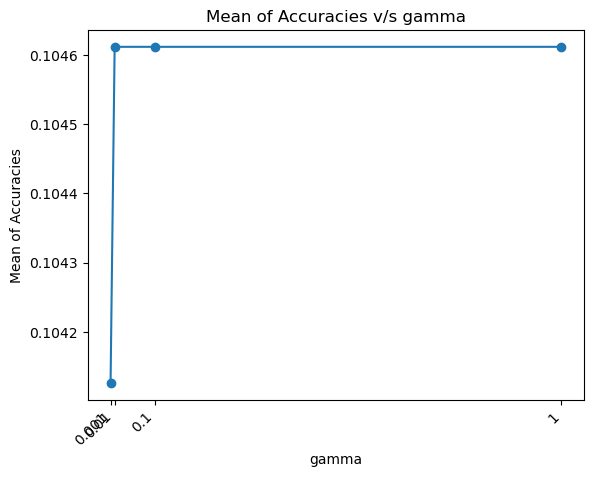

In [34]:
fig, ax = plt.subplots()


ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

# Show the plot
plt.show()

In [35]:
svm_poly_tunned = SVC(kernel='poly', gamma=poly_best_params_initial['gamma'], C =poly_best_params_initial['C'] )
svm_poly_tunned.fit(X_train_70, y_train_70)

SVC(C=0.1, gamma=0.01, kernel='poly')

In [36]:
joblib.dump(svm_poly_tunned,'svm_poly_ALL_n_t_70.joblib')

['svm_poly_ALL_n_t_70.joblib']

In [37]:
poly_t_pred_y_70 = svm_poly_tunned.predict(X_test_70)

In [38]:
poly_t_accuracy = accuracy_score(y_test_70,poly_t_pred_y_70)
print("Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is ",poly_t_accuracy)

Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is  0.3992248062015504


In [39]:
print(classification_report(y_test_70,poly_t_pred_y_70))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.06      0.11        17
     Colin_Powell       0.00      0.00      0.00        48
  Donald_Rumsfeld       0.00      0.00      0.00        19
    George_W_Bush       0.40      1.00      0.57       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.00      0.00      0.00        28

         accuracy                           0.40       258
        macro avg       0.20      0.15      0.10       258
     weighted avg       0.22      0.40      0.23       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

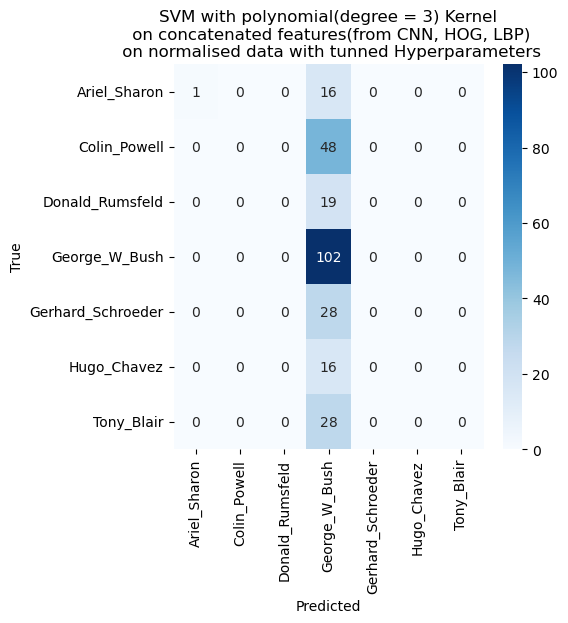

In [40]:
cm_svm_poly_ALL_n_t = confusion_matrix(y_test_70, poly_t_pred_y_70)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_ALL_n_t, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly_tunned.classes_, yticklabels=svm_poly_tunned.classes_, ax=axes)
axes.set_title('SVM with polynomial(degree = 3) Kernel\n on concatenated features(from CNN, HOG, LBP)\n on normalised data with tunned Hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

### RBF Kernel

In [41]:
# svm_rbf = joblib.load('svm_rbf_ALL_n_70.joblib')

In [42]:
rbf_pred_y_70 = svm_rbf.predict(X_test_70)

In [43]:
rbf_accuracy = accuracy_score(y_test_70,rbf_pred_y_70)
print("Accuracy of SVM with RBF kernel is ",rbf_accuracy)

Accuracy of SVM with RBF kernel is  0.6085271317829457


In [44]:
print(classification_report(y_test_70,rbf_pred_y_70))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.24      0.38        17
     Colin_Powell       0.95      0.79      0.86        48
  Donald_Rumsfeld       1.00      0.21      0.35        19
    George_W_Bush       0.51      1.00      0.67       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       1.00      0.32      0.49        28

         accuracy                           0.61       258
        macro avg       0.64      0.37      0.39       258
     weighted avg       0.63      0.61      0.53       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

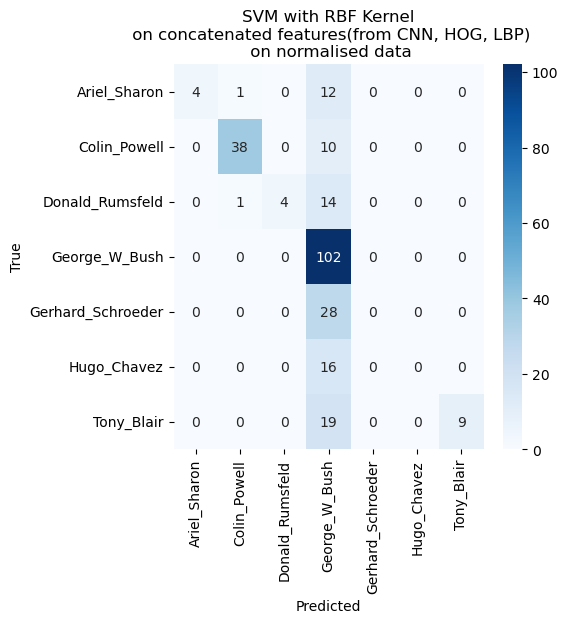

In [45]:
cm_svm_rbf_ALL_n = confusion_matrix(y_test_70, rbf_pred_y_70)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_ALL_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf.classes_, yticklabels=svm_rbf.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on concatenated features(from CNN, HOG, LBP)\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

#### Tuning Hyperparameteres

In [46]:
# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search_i = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_i.fit(X_train_70, y_train_70)

# Best parameters
rbf_best_params_initial = grid_search_i.best_params_
rbf_best_params_initial

{'C': 10, 'gamma': 0.001}

In [47]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + grid_search_i.cv_results_['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + grid_search_i.cv_results_['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)


[0.4155339805825243, 0.41699029126213594, 0.4169902912621359, 0.4169902912621359]
[0.10388349514563107, 0.10533980582524272, 0.10533980582524272, 0.10533980582524272]


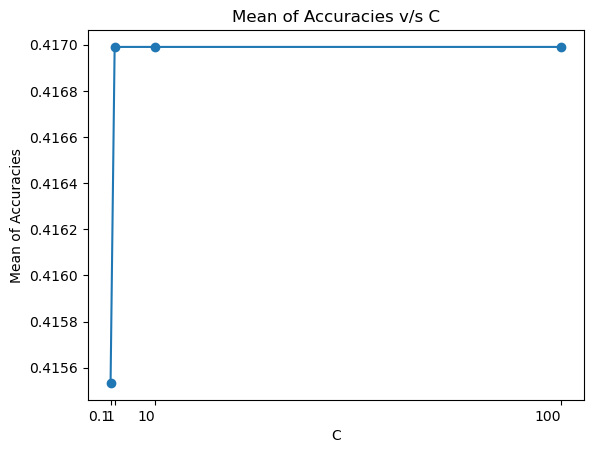

In [48]:
fig, ax = plt.subplots()
ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

plt.show()


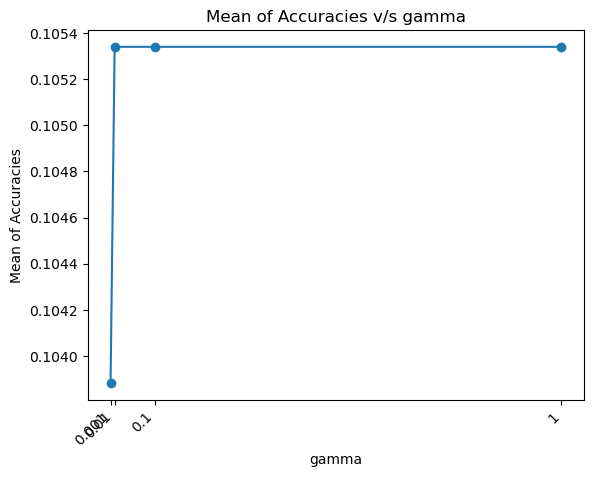

In [49]:
fig, ax = plt.subplots()
ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

plt.show()

In [50]:
svm_rbf_tunned = SVC(kernel='rbf', gamma=rbf_best_params_initial['gamma'], C =rbf_best_params_initial['C'] )
svm_rbf_tunned.fit(X_train_70, y_train_70)

SVC(C=10, gamma=0.001)

In [51]:
joblib.dump(svm_rbf_tunned,'svm_rbf_ALL_n_ti_70.joblib')

['svm_rbf_ALL_n_ti_70.joblib']

In [52]:
rbf_t_pred_y_70 = svm_rbf_tunned.predict(X_test_70)

In [53]:
rbf_t_accuracy = accuracy_score(y_test_70,rbf_t_pred_y_70)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.45348837209302323


In [54]:
print(classification_report(y_test_70,rbf_t_pred_y_70))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        17
     Colin_Powell       1.00      0.27      0.43        48
  Donald_Rumsfeld       1.00      0.05      0.10        19
    George_W_Bush       0.42      1.00      0.59       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       1.00      0.04      0.07        28

         accuracy                           0.45       258
        macro avg       0.49      0.19      0.17       258
     weighted avg       0.53      0.45      0.33       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

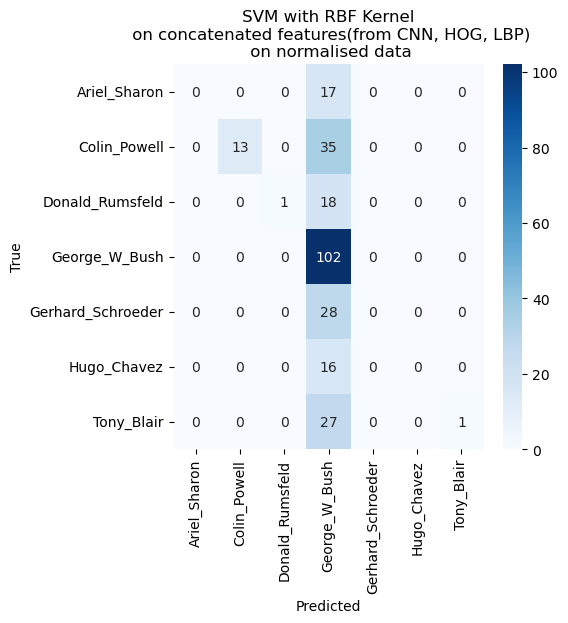

In [55]:
cm_svm_rbf_ALL_n = confusion_matrix(y_test_70, rbf_t_pred_y_70)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_ALL_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_tunned.classes_, yticklabels=svm_rbf_tunned.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on concatenated features(from CNN, HOG, LBP)\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

In [56]:
# Defining the starting and ending points for C and gamma, and the number of points
start_C = 1
end_C = 100
num_C = 10

start_gamma = 0.001
end_gamma = 0.1
num_gamma = 10

# Parameter grid with specified ranges and number of points
param_grid = {'C': np.linspace(start_C, end_C, num_C),
              'gamma': np.linspace(start_gamma, end_gamma, num_gamma)}


# Performing grid search
grid_search_f = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5 , scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_f.fit(X_train_70, y_train_70)

# Best parameters
rbf_best_params_final = grid_search_f.best_params_
rbf_best_accuracy_final = grid_search_f.best_score_
rbf_best_params_final

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'C': 12.0, 'gamma': 0.001}

In [57]:
svm_rbf_tunned_f = SVC(kernel='rbf', gamma=rbf_best_params_final['gamma'], C =rbf_best_params_final['C'] )
svm_rbf_tunned_f.fit(X_train_70, y_train_70)

SVC(C=12.0, gamma=0.001)

In [58]:
joblib.dump(svm_rbf_tunned_f,'svm_rbf_ALL_n_tf_70.joblib')

['svm_rbf_ALL_n_tf_70.joblib']

In [59]:
rbf_t_pred_y_70_f = svm_rbf_tunned_f.predict(X_test_70)

In [60]:
rbf_t_accuracy_f = accuracy_score(y_test_70,rbf_t_pred_y_70_f)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy_f)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.45348837209302323


In [61]:
print(classification_report(y_test_70,rbf_t_pred_y_70_f))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        17
     Colin_Powell       1.00      0.27      0.43        48
  Donald_Rumsfeld       1.00      0.05      0.10        19
    George_W_Bush       0.42      1.00      0.59       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       1.00      0.04      0.07        28

         accuracy                           0.45       258
        macro avg       0.49      0.19      0.17       258
     weighted avg       0.53      0.45      0.33       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

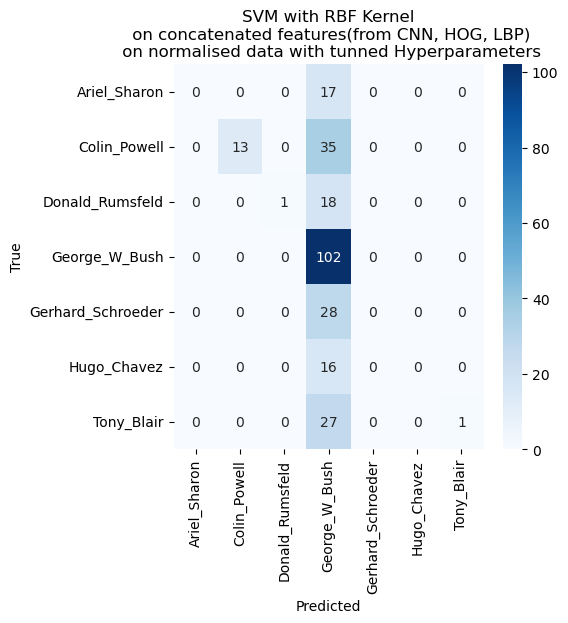

In [62]:
cm_svm_rbf_ALL_n_t = confusion_matrix(y_test_70, rbf_t_pred_y_70_f)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_ALL_n_t, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_tunned_f.classes_, yticklabels=svm_rbf_tunned_f.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on concatenated features(from CNN, HOG, LBP)\n on normalised data with tunned Hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

# CNN HOG LBP Features seperately

In [63]:
X_hog = X_70.loc[:,:944]
X_cnn = X_70.loc[:,945:2992]
X_lbp = X_70.loc[:,2993:]

In [64]:
# X_hog
# X_cnn
# X_lbp

## CNN Features

In [65]:
X_train_70_df_cnn, X_test_70_df_cnn, y_train_70_cnn, y_test_70_cnn = train_test_split(X_cnn,y_70,train_size=0.8,random_state=42)
X_train_70_df_cnn.reset_index(drop=True, inplace = True)
X_test_70_df_cnn.reset_index(drop=True, inplace = True)
y_train_70_cnn.reset_index(drop=True, inplace = True)
y_test_70_cnn.reset_index(drop=True, inplace = True)

In [66]:
#Normalising the data
scaler_cnn=StandardScaler()
X_train_arr=X_train_70_df_cnn.values
X_test_arr=X_test_70_df_cnn.values
X_train_arr_n=scaler_cnn.fit_transform(X_train_arr)
joblib.dump(scaler_cnn,'Standard_Scalar_Normalisation_cnn_70.joblib')
X_test_arr_n = scaler_cnn.transform(X_test_arr)
X_train_70_cnn = pd.DataFrame(X_train_arr_n)
X_test_70_cnn = pd.DataFrame(X_test_arr_n)
# X_train_70_cnn

### LinearSVC

In [67]:
# Training Linear Support Vector Classifier (LinearSVC)
lin_clf_cnn = svm.LinearSVC(dual=False)
lin_clf_cnn.fit(X_train_70_cnn, y_train_70_cnn)
joblib.dump(lin_clf_cnn,'linearSVC_cnn_70.joblib')

C:\Users\bharm\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['linearSVC_cnn_70.joblib']

In [68]:
pred_y_test_70_cnn = lin_clf_cnn.predict(X_test_70_cnn)

In [69]:
# Accuracy of linearSVC model
linSVC_accuracy = lin_clf_cnn.score(X_test_70_cnn, y_test_70_cnn)
print("Accuracy of linearSVC is ",linSVC_accuracy)

Accuracy of linearSVC is  0.7596899224806202


In [70]:
# Classification Report of linearSVC model
print(classification_report(y_test_70_cnn,pred_y_test_70_cnn))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.93      0.82      0.88        17
     Colin_Powell       0.76      0.92      0.83        48
  Donald_Rumsfeld       0.75      0.63      0.69        19
    George_W_Bush       0.83      0.83      0.83       102
Gerhard_Schroeder       0.55      0.43      0.48        28
      Hugo_Chavez       0.67      0.62      0.65        16
       Tony_Blair       0.63      0.68      0.66        28

         accuracy                           0.76       258
        macro avg       0.73      0.71      0.71       258
     weighted avg       0.76      0.76      0.76       258



Text(33.081597222222214, 0.5, 'True')

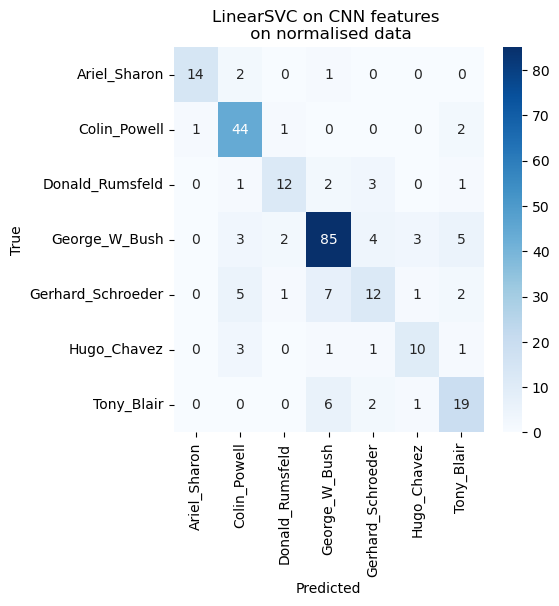

In [71]:
cm_linearSVC_cnn_n = confusion_matrix(y_test_70_cnn, pred_y_test_70_cnn)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_linearSVC_cnn_n, annot=True, fmt="d", cmap="Blues", xticklabels=lin_clf_cnn.classes_, yticklabels=lin_clf_cnn.classes_, ax=axes)
axes.set_title('LinearSVC on CNN features \n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

### SVM Models with Linear, polynomial and rbf kernals

In [72]:
svm_linear_cnn = SVC(kernel='linear') # linear kernal
svm_poly_cnn = SVC(kernel='poly', degree= 3)  # Polynomial kernel of degree 3
svm_rbf_cnn = SVC(kernel='rbf')  # RBF kernel

In [73]:
svm_linear_cnn.fit(X_train_70_cnn, y_train_70_cnn)
svm_poly_cnn.fit(X_train_70_cnn, y_train_70_cnn)
svm_rbf_cnn.fit(X_train_70_cnn, y_train_70_cnn)

SVC()

In [74]:
joblib.dump(svm_linear_cnn,'svm_linear_cnn_n_70.joblib')
joblib.dump(svm_poly_cnn,'svm_poly_cnn_n_70.joblib')
joblib.dump(svm_rbf_cnn,'svm_rbf_cnn_n_70.joblib')

['svm_rbf_cnn_n_70.joblib']

#### Linear Kernel

In [75]:
svm_linear_cnn.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [76]:
lin_pred_y_70_cnn = svm_linear_cnn.predict(X_test_70_cnn)

In [77]:
lin_accuracy_cnn = accuracy_score(y_test_70_cnn,lin_pred_y_70_cnn)
print("Accuracy of SVM with Linear kernel is ",lin_accuracy_cnn)

Accuracy of SVM with Linear kernel is  0.7868217054263565


In [78]:
print(classification_report(y_test_70_cnn,lin_pred_y_70_cnn))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.82      0.90        17
     Colin_Powell       0.81      0.88      0.84        48
  Donald_Rumsfeld       0.93      0.74      0.82        19
    George_W_Bush       0.76      0.90      0.83       102
Gerhard_Schroeder       0.62      0.36      0.45        28
      Hugo_Chavez       0.79      0.69      0.73        16
       Tony_Blair       0.77      0.71      0.74        28

         accuracy                           0.79       258
        macro avg       0.81      0.73      0.76       258
     weighted avg       0.79      0.79      0.78       258



Text(33.081597222222214, 0.5, 'True')

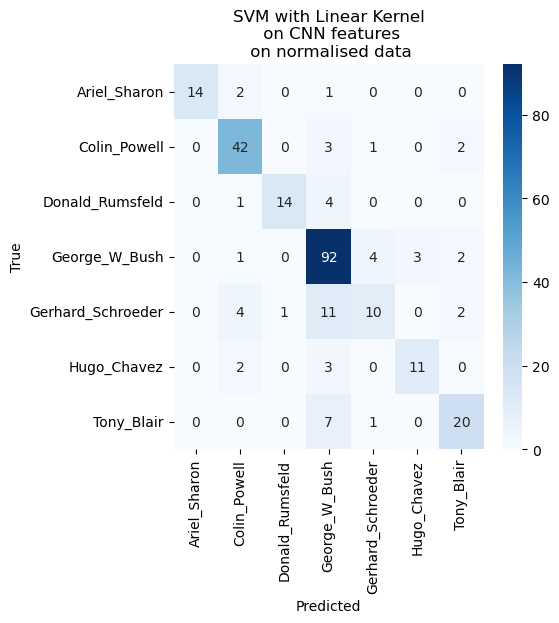

In [79]:
cm_svm_linear_cnn_n = confusion_matrix(y_test_70, lin_pred_y_70_cnn)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_linear_cnn_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_linear_cnn.classes_, yticklabels=svm_linear_cnn.classes_, ax=axes)
axes.set_title('SVM with Linear Kernel\n on CNN features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tunning Hyperparameter

In [80]:
c_values = [0.1, 1, 10, 100]

accuracy_values_cnn = []
predicted_values_cnn = []

for i in c_values:
    svm_lin_tunned_cnn = SVC(kernel='linear', C = i )
    svm_lin_tunned_cnn.fit(X_train_70_cnn, y_train_70_cnn)
    lin_t_pred_y_70_cnn = svm_lin_tunned_cnn.predict(X_test_70_cnn)
    lin_t_accuracy_cnn = accuracy_score(y_test_70_cnn,lin_t_pred_y_70_cnn)
    
    accuracy_values_cnn.append(lin_t_accuracy_cnn)
    predicted_values_cnn.append(lin_t_pred_y_70_cnn)
    
print(accuracy_values_cnn)

[0.7868217054263565, 0.7868217054263565, 0.7868217054263565, 0.7868217054263565]


Therefor, value of c (between 0.1 to 100) is not affecting the accuracy.
So, no requirement of hyperparameter tuning.

#### Polynomial Kernel

In [81]:
svm_poly_cnn.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [82]:
poly_pred_y_70_cnn = svm_poly_cnn.predict(X_test_70_cnn)

In [83]:
poly_accuracy_cnn = accuracy_score(y_test_70_cnn,poly_pred_y_70_cnn)
print("Accuracy of SVM with polynomial kernel (of degree 3) is ",poly_accuracy_cnn)

Accuracy of SVM with polynomial kernel (of degree 3) is  0.3953488372093023


In [84]:
print(classification_report(y_test_70_cnn,poly_pred_y_70_cnn))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.06      0.11        17
     Colin_Powell       0.00      0.00      0.00        48
  Donald_Rumsfeld       0.00      0.00      0.00        19
    George_W_Bush       0.39      0.97      0.56       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.50      0.12      0.20        16
       Tony_Blair       0.00      0.00      0.00        28

         accuracy                           0.40       258
        macro avg       0.27      0.16      0.12       258
     weighted avg       0.25      0.40      0.24       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

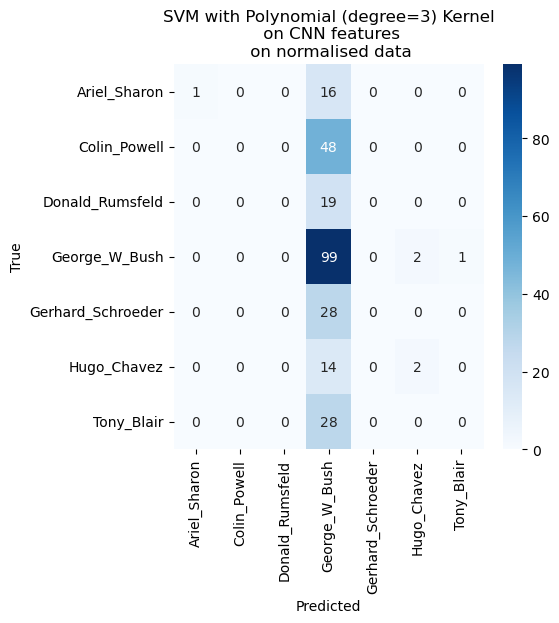

In [85]:
cm_svm_poly_cnn_n = confusion_matrix(y_test_70, poly_pred_y_70_cnn)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_cnn_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly_cnn.classes_, yticklabels=svm_poly_cnn.classes_, ax=axes)
axes.set_title('SVM with Polynomial (degree=3) Kernel\n on CNN features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tuning Hyperparameters

In [86]:
# Defining parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search_cnn_poly = GridSearchCV(estimator=svm_poly_cnn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_cnn_poly.fit(X_train_70_cnn,y_train_70_cnn)

# Best parameters
poly_best_params_initial_cnn = grid_search_cnn_poly.best_params_
poly_best_params_initial_cnn

{'C': 0.1, 'gamma': 0.01}

In [87]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + grid_search_cnn_poly.cv_results_['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + grid_search_cnn_poly.cv_results_['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)

[0.44490291262135917, 0.44660194174757284, 0.4466019417475728, 0.4466019417475728]
[0.104126213592233, 0.1058252427184466, 0.1058252427184466, 0.1058252427184466]


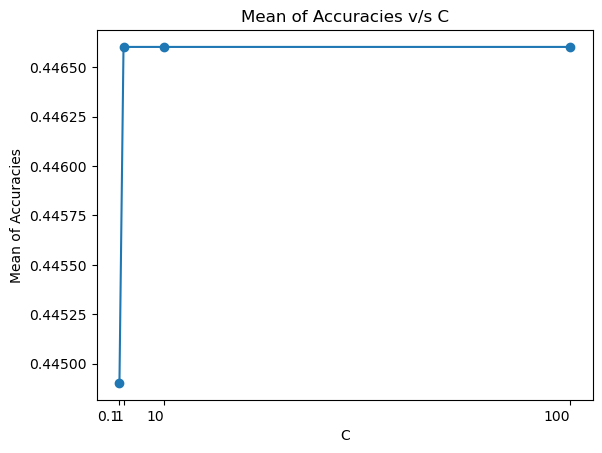

In [88]:
fig, ax = plt.subplots()
ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

plt.show()


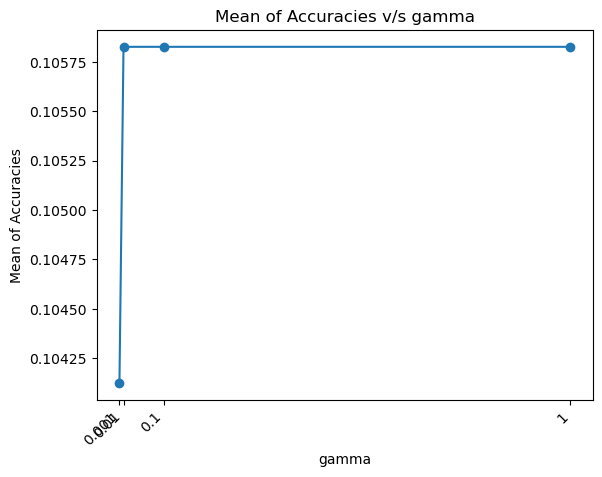

In [89]:
fig, ax = plt.subplots()
ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

plt.show()

In [90]:
svm_poly_tunned_cnn = SVC(kernel='poly', gamma=poly_best_params_initial_cnn['gamma'], C =poly_best_params_initial_cnn['C'] )
svm_poly_tunned_cnn.fit(X_train_70_cnn, y_train_70_cnn)

SVC(C=0.1, gamma=0.01, kernel='poly')

In [91]:
joblib.dump(svm_poly_tunned_cnn,'svm_poly_cnn_n_t_70.joblib')

['svm_poly_cnn_n_t_70.joblib']

In [92]:
poly_t_pred_y_70_cnn = svm_poly_tunned_cnn.predict(X_test_70_cnn)

In [93]:
poly_t_accuracy_cnn = accuracy_score(y_test_70_cnn,poly_t_pred_y_70_cnn)
print("Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is ",poly_t_accuracy_cnn)

Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is  0.46511627906976744


In [94]:
print(classification_report(y_test_70_cnn,poly_t_pred_y_70_cnn))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.57      0.24      0.33        17
     Colin_Powell       0.88      0.29      0.44        48
  Donald_Rumsfeld       0.00      0.00      0.00        19
    George_W_Bush       0.43      0.94      0.59       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.71      0.31      0.43        16
       Tony_Blair       0.25      0.04      0.06        28

         accuracy                           0.47       258
        macro avg       0.41      0.26      0.27       258
     weighted avg       0.44      0.47      0.37       258



Text(33.081597222222214, 0.5, 'True')

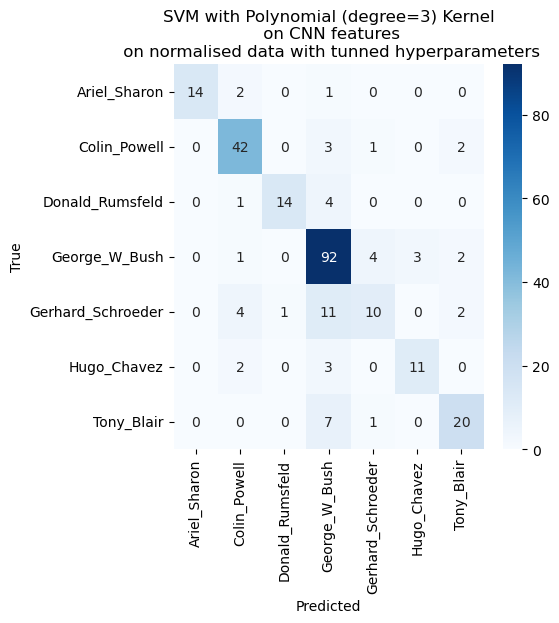

In [95]:
cm_svm_poly_cnn_n_t = confusion_matrix(y_test_70, lin_pred_y_70_cnn)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_cnn_n_t, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly_tunned_cnn.classes_, yticklabels=svm_poly_tunned_cnn.classes_, ax=axes)
axes.set_title('SVM with Polynomial (degree=3) Kernel\n on CNN features\n on normalised data with tunned hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')


#### RBF Kernel

In [96]:
rbf_pred_y_70_cnn = svm_rbf_cnn.predict(X_test_70_cnn)

In [97]:
rbf_accuracy_cnn = accuracy_score(y_test_70_cnn,rbf_pred_y_70_cnn)
print("Accuracy of SVM with RBF kernel is ",rbf_accuracy_cnn)

Accuracy of SVM with RBF kernel is  0.5775193798449613


In [98]:
print(classification_report(y_test_70_cnn,rbf_pred_y_70_cnn))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.29      0.45        17
     Colin_Powell       0.85      0.69      0.76        48
  Donald_Rumsfeld       1.00      0.21      0.35        19
    George_W_Bush       0.50      0.99      0.66       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       1.00      0.21      0.35        28

         accuracy                           0.58       258
        macro avg       0.62      0.34      0.37       258
     weighted avg       0.60      0.58      0.50       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

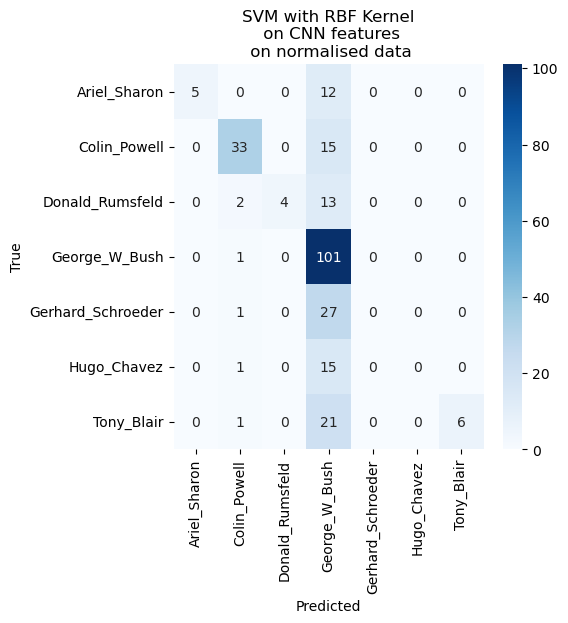

In [99]:
cm_svm_rbf_cnn_n = confusion_matrix(y_test_70, rbf_pred_y_70_cnn)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_cnn_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_cnn.classes_, yticklabels=svm_rbf_cnn.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on CNN features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tuning Hyperparameteres

In [100]:
# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search_cnn_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_cnn_rbf.fit(X_train_70_cnn, y_train_70_cnn)

# Best parameters
rbf_best_params_initial_cnn = grid_search_cnn_rbf.best_params_
rbf_best_params_initial_cnn

{'C': 10, 'gamma': 0.001}

In [101]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + grid_search_cnn_rbf.cv_results_['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + grid_search_cnn_rbf.cv_results_['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)

[0.4155339805825243, 0.4436893203883495, 0.4436893203883495, 0.4436893203883495]
[0.10388349514563107, 0.13203883495145632, 0.13203883495145632, 0.13203883495145632]


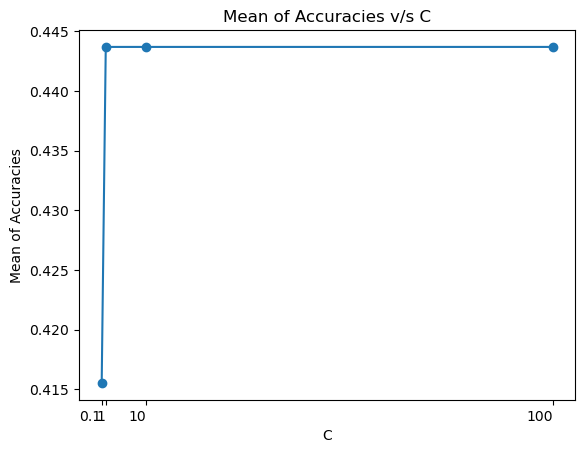

In [102]:
fig, ax = plt.subplots()
ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

plt.show()

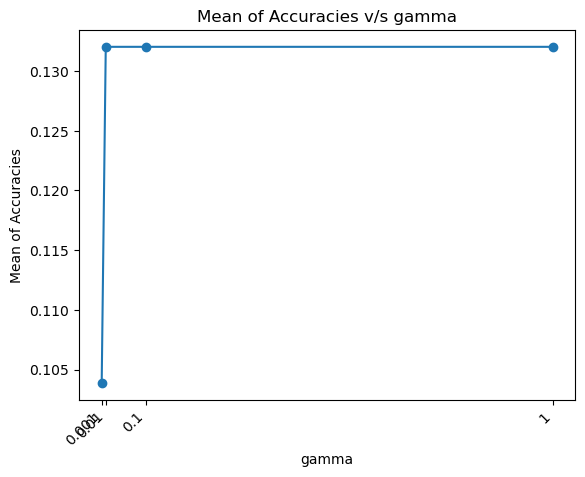

In [103]:
fig, ax = plt.subplots()
ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

plt.show()

In [104]:
svm_rbf_tunned_cnn = SVC(kernel='rbf', gamma=rbf_best_params_initial_cnn['gamma'], C =rbf_best_params_initial_cnn['C'] )
svm_rbf_tunned_cnn.fit(X_train_70_cnn, y_train_70_cnn)

SVC(C=10, gamma=0.001)

In [105]:
joblib.dump(svm_rbf_tunned_cnn,'svm_rbf_cnn_n_ti_70.joblib')

['svm_rbf_cnn_n_ti_70.joblib']

In [106]:
rbf_t_pred_y_70_cnn = svm_rbf_tunned_cnn.predict(X_test_70_cnn)

In [107]:
rbf_t_accuracy_cnn = accuracy_score(y_test_70_cnn,rbf_t_pred_y_70_cnn)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy_cnn)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.5852713178294574


In [108]:
print(classification_report(y_test_70_cnn,rbf_t_pred_y_70_cnn))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.12      0.21        17
     Colin_Powell       0.83      0.62      0.71        48
  Donald_Rumsfeld       1.00      0.16      0.27        19
    George_W_Bush       0.50      0.99      0.67       102
Gerhard_Schroeder       1.00      0.07      0.13        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.93      0.46      0.62        28

         accuracy                           0.59       258
        macro avg       0.75      0.35      0.37       258
     weighted avg       0.70      0.59      0.51       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [109]:
# Defining the starting and ending points for C and gamma, and the number of points
start_C = 1
end_C = 100
num_C = 10

start_gamma = 0.001
end_gamma = 0.1
num_gamma = 5

# Parameter grid with specified ranges and number of points
param_grid = {'C': np.linspace(start_C, end_C, num_C),
              'gamma': np.linspace(start_gamma, end_gamma, num_gamma)}


# Performing grid search
grid_search_cnn_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5 , scoring='accuracy', n_jobs=-1)
grid_search_cnn_rbf.fit(X_train_70_cnn, y_train_70_cnn)

# Best parameters
rbf_best_params_final_cnn = grid_search_cnn_rbf.best_params_
rbf_best_accuracy_final_cnn = grid_search_cnn_rbf.best_score_
rbf_best_params_final_cnn

{'C': 12.0, 'gamma': 0.001}

In [110]:
svm_rbf_tunned_f_cnn = SVC(kernel='rbf', gamma=rbf_best_params_final_cnn['gamma'], C =rbf_best_params_final_cnn['C'] )
svm_rbf_tunned_f_cnn.fit(X_train_70_cnn, y_train_70_cnn)

SVC(C=12.0, gamma=0.001)

In [111]:
joblib.dump(svm_rbf_tunned_f_cnn,'svm_rbf_cnn_n_tf_70.joblib')

['svm_rbf_cnn_n_tf_70.joblib']

In [112]:
rbf_t_pred_y_70_f_cnn = svm_rbf_tunned_f_cnn.predict(X_test_70_cnn)

In [113]:
rbf_t_accuracy_f_cnn = accuracy_score(y_test_70_cnn,rbf_t_pred_y_70_f_cnn)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy_f_cnn)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.5852713178294574


In [114]:
print(classification_report(y_test_70_cnn,rbf_t_pred_y_70_f_cnn))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.12      0.21        17
     Colin_Powell       0.83      0.62      0.71        48
  Donald_Rumsfeld       1.00      0.16      0.27        19
    George_W_Bush       0.50      0.99      0.67       102
Gerhard_Schroeder       1.00      0.07      0.13        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.93      0.46      0.62        28

         accuracy                           0.59       258
        macro avg       0.75      0.35      0.37       258
     weighted avg       0.70      0.59      0.51       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

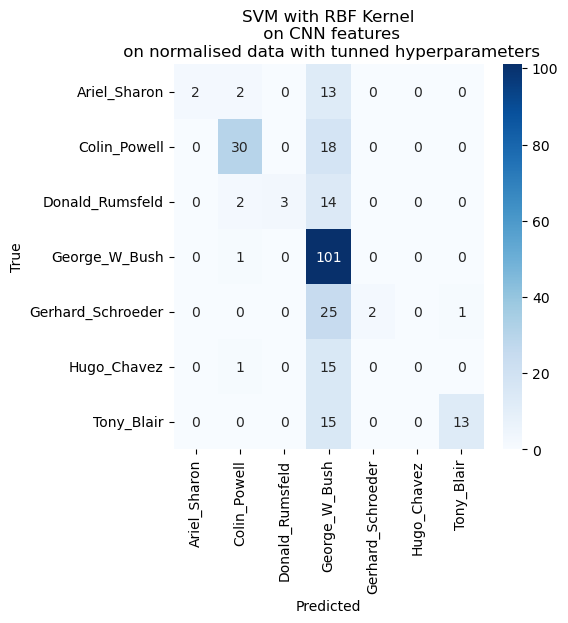

In [115]:
cm_svm_rbf_cnn_n_tf = confusion_matrix(y_test_70, rbf_t_pred_y_70_f_cnn)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_cnn_n_tf, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_tunned_f_cnn.classes_, yticklabels=svm_rbf_tunned_f_cnn.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on CNN features\n on normalised data with tunned hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

## HoG Features

In [116]:
X_train_70_df_hog, X_test_70_df_hog, y_train_70_hog, y_test_70_hog = train_test_split(X_hog,y_70,train_size=0.8,random_state=42)
X_train_70_df_hog.reset_index(drop=True, inplace = True)
X_test_70_df_hog.reset_index(drop=True, inplace = True)
y_train_70_hog.reset_index(drop=True, inplace = True)
y_test_70_hog.reset_index(drop=True, inplace = True)

In [117]:
#Normalising the data
scaler_hog=StandardScaler()
X_train_arr=X_train_70_df_hog.values
X_test_arr=X_test_70_df_hog.values
X_train_arr_n=scaler_hog.fit_transform(X_train_arr)
joblib.dump(scaler_hog,'Standard_Scalar_Normalisation_hog_70.joblib')
X_test_arr_n = scaler_hog.transform(X_test_arr)
X_train_70_hog = pd.DataFrame(X_train_arr_n)
X_test_70_hog = pd.DataFrame(X_test_arr_n)
# X_train_70_hog

### LinearSVC

In [118]:
# Training Linear Support Vector Classifier (LinearSVC)
lin_clf_hog = svm.LinearSVC(dual=False)
lin_clf_hog.fit(X_train_70_hog, y_train_70_hog)
joblib.dump(lin_clf_hog,'linearSVC_hog_70.joblib')

C:\Users\bharm\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['linearSVC_hog_70.joblib']

In [119]:
pred_y_test_70_hog = lin_clf_hog.predict(X_test_70_hog)

In [120]:
# Accuracy of linearSVC model
linSVC_accuracy = lin_clf_hog.score(X_test_70_hog, y_test_70_hog)
print("Accuracy of linearSVC is ",linSVC_accuracy)

Accuracy of linearSVC is  0.8488372093023255


In [121]:
# Classification Report of linearSVC model
print(classification_report(y_test_70_hog,pred_y_test_70_hog))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.77      0.59      0.67        17
     Colin_Powell       0.84      1.00      0.91        48
  Donald_Rumsfeld       0.62      0.68      0.65        19
    George_W_Bush       0.95      0.90      0.92       102
Gerhard_Schroeder       0.87      0.71      0.78        28
      Hugo_Chavez       0.60      0.75      0.67        16
       Tony_Blair       0.89      0.86      0.87        28

         accuracy                           0.85       258
        macro avg       0.79      0.79      0.78       258
     weighted avg       0.86      0.85      0.85       258



Text(33.081597222222214, 0.5, 'True')

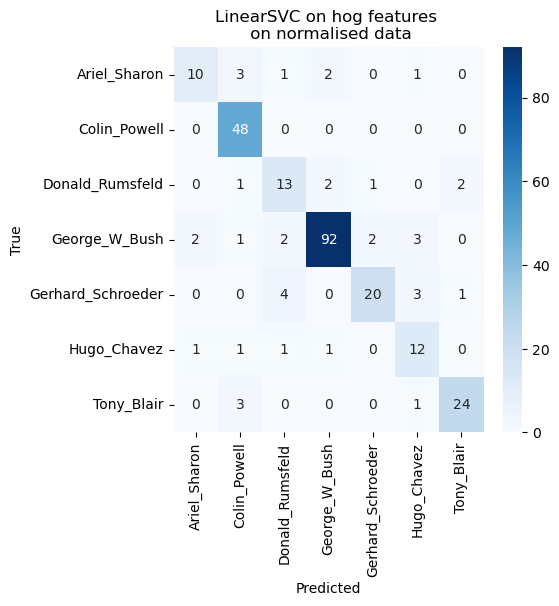

In [122]:
cm_linearSVC_hog_n = confusion_matrix(y_test_70_hog, pred_y_test_70_hog)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_linearSVC_hog_n, annot=True, fmt="d", cmap="Blues", xticklabels=lin_clf_hog.classes_, yticklabels=lin_clf_hog.classes_, ax=axes)
axes.set_title('LinearSVC on hog features \n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

### SVM Models with Linear, polynomial and rbf kernals

In [123]:
svm_linear_hog = SVC(kernel='linear') # linear kernal
svm_poly_hog = SVC(kernel='poly', degree= 3)  # Polynomial kernel of degree 3
svm_rbf_hog = SVC(kernel='rbf')  # RBF kernel

In [124]:
svm_linear_hog.fit(X_train_70_hog, y_train_70_hog)
svm_poly_hog.fit(X_train_70_hog, y_train_70_hog)
svm_rbf_hog.fit(X_train_70_hog, y_train_70_hog)

SVC()

In [125]:
joblib.dump(svm_linear_hog,'svm_linear_hog_n_70.joblib')
joblib.dump(svm_poly_hog,'svm_poly_hog_n_70.joblib')
joblib.dump(svm_rbf_hog,'svm_rbf_hog_n_70.joblib')

['svm_rbf_hog_n_70.joblib']

#### Linear Kernel

In [126]:
svm_linear_hog.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [127]:
lin_pred_y_70_hog = svm_linear_hog.predict(X_test_70_hog)

In [128]:
lin_accuracy_hog = accuracy_score(y_test_70_hog,lin_pred_y_70_hog)
print("Accuracy of SVM with Linear kernel is ",lin_accuracy_hog)

Accuracy of SVM with Linear kernel is  0.872093023255814


In [129]:
print(classification_report(y_test_70_hog,lin_pred_y_70_hog))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.86      0.71      0.77        17
     Colin_Powell       0.88      0.94      0.91        48
  Donald_Rumsfeld       0.76      0.68      0.72        19
    George_W_Bush       0.85      0.99      0.91       102
Gerhard_Schroeder       0.95      0.71      0.82        28
      Hugo_Chavez       0.91      0.62      0.74        16
       Tony_Blair       0.96      0.86      0.91        28

         accuracy                           0.87       258
        macro avg       0.88      0.79      0.83       258
     weighted avg       0.88      0.87      0.87       258



Text(33.081597222222214, 0.5, 'True')

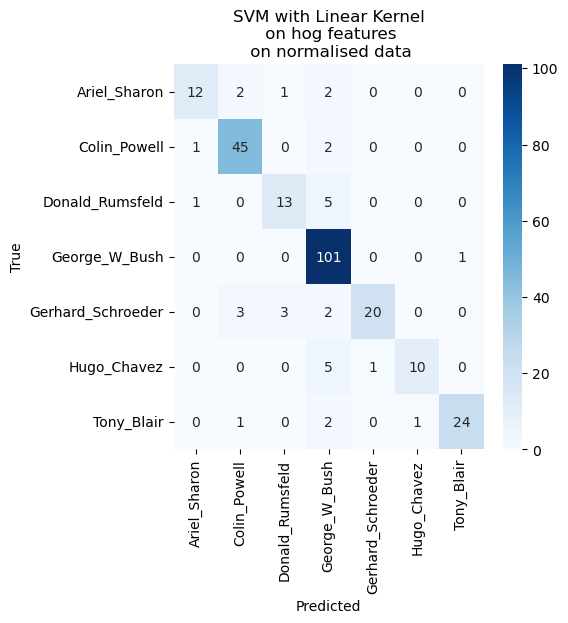

In [130]:
cm_svm_linear_hog_n = confusion_matrix(y_test_70, lin_pred_y_70_hog)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_linear_hog_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_linear_hog.classes_, yticklabels=svm_linear_hog.classes_, ax=axes)
axes.set_title('SVM with Linear Kernel\n on hog features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tunning Hyperparameter

In [131]:
c_values = [0.1, 1, 10, 100]

accuracy_values_hog = []
predicted_values_hog = []

for i in c_values:
    svm_lin_tunned_hog = SVC(kernel='linear', C = i )
    svm_lin_tunned_hog.fit(X_train_70_hog, y_train_70_hog)
    lin_t_pred_y_70_hog = svm_lin_tunned_hog.predict(X_test_70_hog)
    lin_t_accuracy_hog = accuracy_score(y_test_70_hog,lin_t_pred_y_70_hog)
    
    accuracy_values_hog.append(lin_t_accuracy_hog)
    predicted_values_hog.append(lin_t_pred_y_70_hog)
    
print(accuracy_values_hog)

[0.872093023255814, 0.872093023255814, 0.872093023255814, 0.872093023255814]


Therefor, value of c (between 0.1 to 100) is not affecting the accuracy.
So, no requirement of hyperparameter tuning.

#### Polynomial Kernel

In [132]:
svm_poly_hog.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [133]:
poly_pred_y_70_hog = svm_poly_hog.predict(X_test_70_hog)

In [134]:
poly_accuracy_hog = accuracy_score(y_test_70_hog,poly_pred_y_70_hog)
print("Accuracy of SVM with polynomial kernel (of degree 3) is ",poly_accuracy_hog)

Accuracy of SVM with polynomial kernel (of degree 3) is  0.3953488372093023


In [135]:
print(classification_report(y_test_70_hog,poly_pred_y_70_hog))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        17
     Colin_Powell       0.00      0.00      0.00        48
  Donald_Rumsfeld       0.00      0.00      0.00        19
    George_W_Bush       0.40      1.00      0.57       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.00      0.00      0.00        28

         accuracy                           0.40       258
        macro avg       0.06      0.14      0.08       258
     weighted avg       0.16      0.40      0.22       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

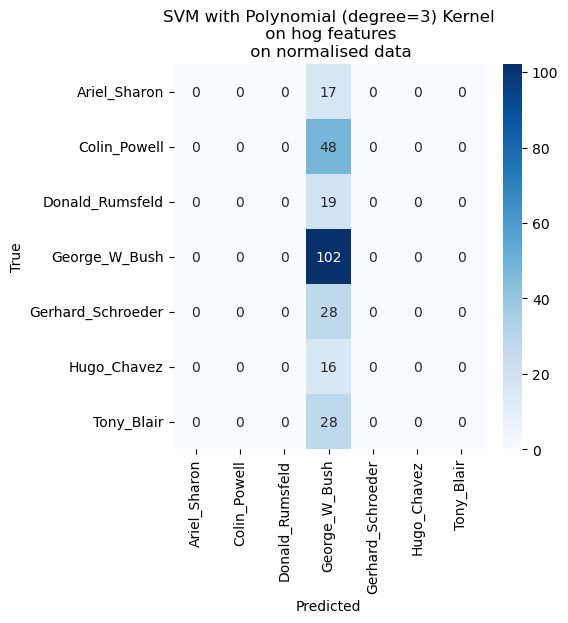

In [136]:
cm_svm_poly_hog_n = confusion_matrix(y_test_70, poly_pred_y_70_hog)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_hog_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly_hog.classes_, yticklabels=svm_poly_hog.classes_, ax=axes)
axes.set_title('SVM with Polynomial (degree=3) Kernel\n on hog features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tuning Hyperparameters

In [137]:
# Defining parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search_hog_poly = GridSearchCV(estimator=svm_poly_hog, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_hog_poly.fit(X_train_70_hog,y_train_70_hog)

# Best parameters
poly_best_params_initial_hog = grid_search_hog_poly.best_params_
poly_best_params_initial_hog

{'C': 0.1, 'gamma': 0.001}

In [138]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + grid_search_hog_poly.cv_results_['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + grid_search_hog_poly.cv_results_['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)

[0.4155339805825243, 0.4155339805825243, 0.4155339805825243, 0.4155339805825243]
[0.10388349514563107, 0.10388349514563107, 0.10388349514563107, 0.10388349514563107]


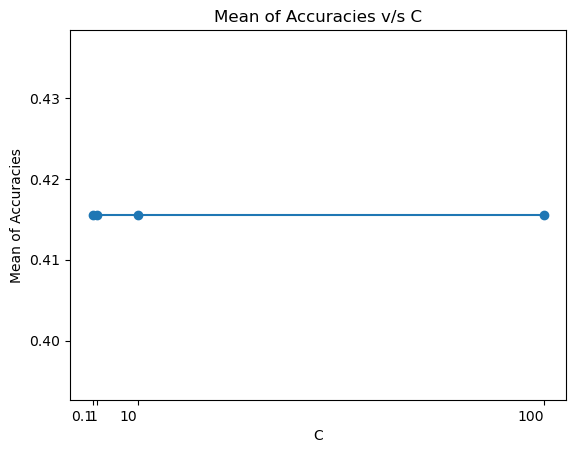

In [139]:
fig, ax = plt.subplots()
ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

plt.show()


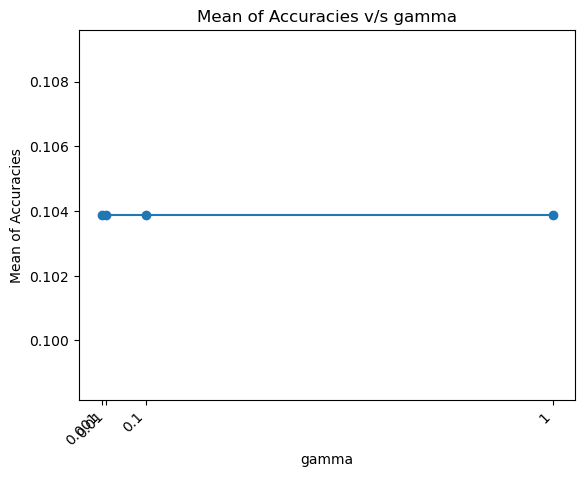

In [140]:
fig, ax = plt.subplots()
ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

plt.show()

In [141]:
svm_poly_tunned_hog = SVC(kernel='poly', gamma=poly_best_params_initial_hog['gamma'], C =poly_best_params_initial_hog['C'] )
svm_poly_tunned_hog.fit(X_train_70_hog, y_train_70_hog)

SVC(C=0.1, gamma=0.001, kernel='poly')

In [142]:
joblib.dump(svm_poly_tunned_hog,'svm_poly_hog_n_t_70.joblib')

['svm_poly_hog_n_t_70.joblib']

In [143]:
poly_t_pred_y_70_hog = svm_poly_tunned_hog.predict(X_test_70_hog)

In [144]:
poly_t_accuracy_hog = accuracy_score(y_test_70_hog,poly_t_pred_y_70_hog)
print("Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is ",poly_t_accuracy_hog)

Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is  0.3953488372093023


In [145]:
print(classification_report(y_test_70_hog,poly_t_pred_y_70_hog))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        17
     Colin_Powell       0.00      0.00      0.00        48
  Donald_Rumsfeld       0.00      0.00      0.00        19
    George_W_Bush       0.40      1.00      0.57       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.00      0.00      0.00        28

         accuracy                           0.40       258
        macro avg       0.06      0.14      0.08       258
     weighted avg       0.16      0.40      0.22       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

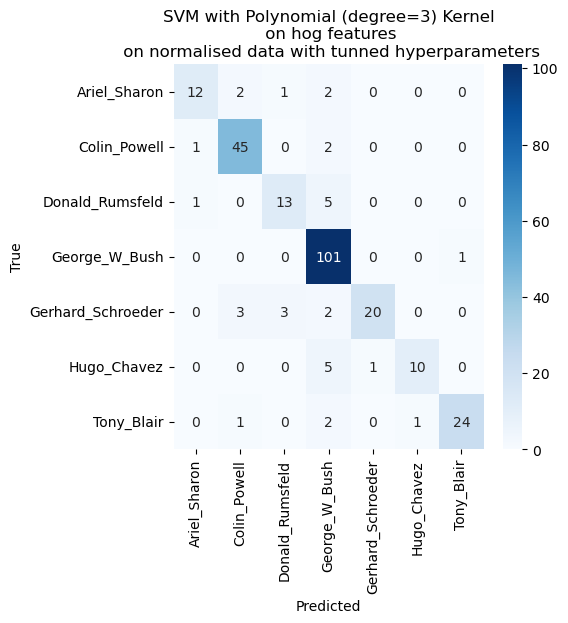

In [146]:
cm_svm_poly_hog_n_t = confusion_matrix(y_test_70, lin_pred_y_70_hog)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_hog_n_t, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly_tunned_hog.classes_, yticklabels=svm_poly_tunned_hog.classes_, ax=axes)
axes.set_title('SVM with Polynomial (degree=3) Kernel\n on hog features\n on normalised data with tunned hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')


#### RBF Kernel

In [147]:
rbf_pred_y_70_hog = svm_rbf_hog.predict(X_test_70_hog)

In [148]:
rbf_accuracy_hog = accuracy_score(y_test_70_hog,rbf_pred_y_70_hog)
print("Accuracy of SVM with RBF kernel is ",rbf_accuracy_hog)

Accuracy of SVM with RBF kernel is  0.5891472868217055


In [149]:
print(classification_report(y_test_70_hog,rbf_pred_y_70_hog))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        17
     Colin_Powell       0.95      0.75      0.84        48
  Donald_Rumsfeld       1.00      0.26      0.42        19
    George_W_Bush       0.50      1.00      0.66       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       1.00      0.32      0.49        28

         accuracy                           0.59       258
        macro avg       0.49      0.33      0.34       258
     weighted avg       0.55      0.59      0.50       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

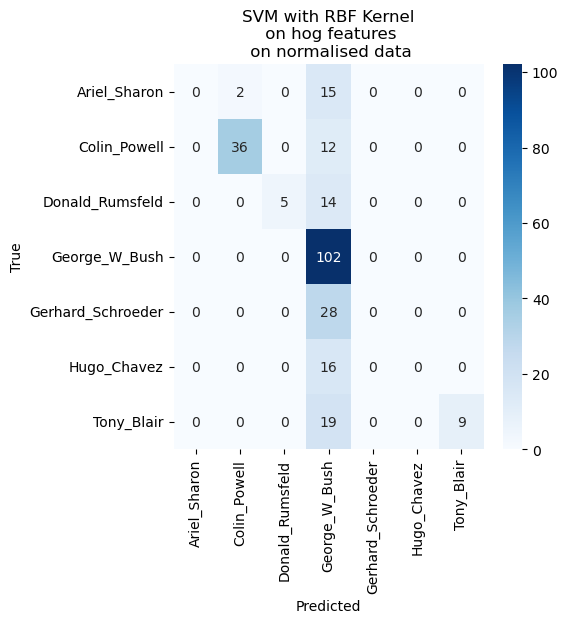

In [150]:
cm_svm_rbf_hog_n = confusion_matrix(y_test_70, rbf_pred_y_70_hog)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_hog_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_hog.classes_, yticklabels=svm_rbf_hog.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on hog features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tuning Hyperparameteres

In [151]:
# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search_hog_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_hog_rbf.fit(X_train_70_hog, y_train_70_hog)

# Best parameters
rbf_best_params_initial_hog = grid_search_hog_rbf.best_params_
rbf_best_params_initial_hog

{'C': 10, 'gamma': 0.001}

In [152]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + grid_search_hog_rbf.cv_results_['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + grid_search_hog_rbf.cv_results_['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)

[0.4155339805825243, 0.4589805825242719, 0.4589805825242718, 0.4589805825242718]
[0.10388349514563107, 0.14733009708737863, 0.14733009708737863, 0.14733009708737863]


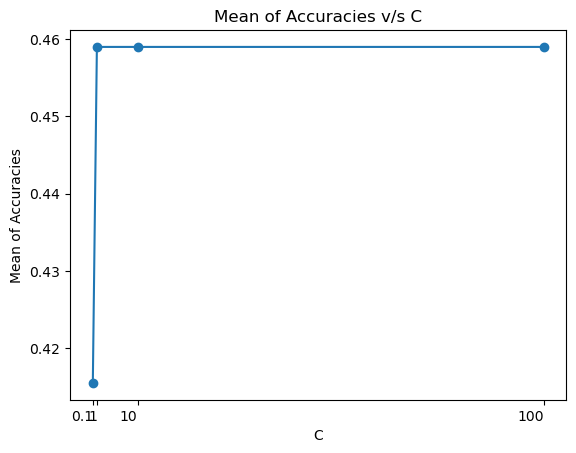

In [153]:
fig, ax = plt.subplots()
ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

plt.show()

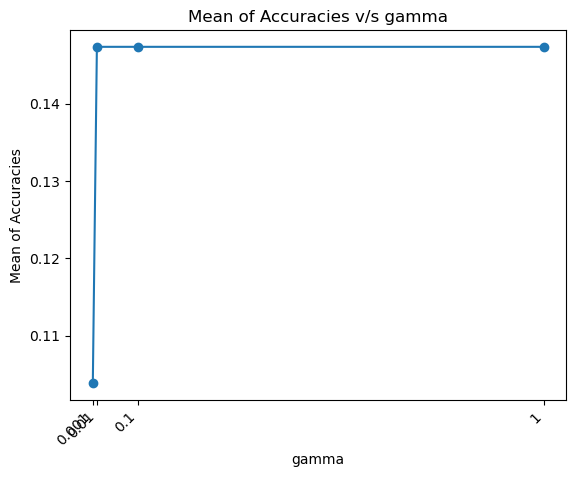

In [154]:
fig, ax = plt.subplots()
ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

plt.show()

In [155]:
svm_rbf_tunned_hog = SVC(kernel='rbf', gamma=rbf_best_params_initial_hog['gamma'], C =rbf_best_params_initial_hog['C'] )
svm_rbf_tunned_hog.fit(X_train_70_hog, y_train_70_hog)

SVC(C=10, gamma=0.001)

In [156]:
joblib.dump(svm_rbf_tunned_hog,'svm_rbf_hog_n_ti_70.joblib')

['svm_rbf_hog_n_ti_70.joblib']

In [157]:
rbf_t_pred_y_70_hog = svm_rbf_tunned_hog.predict(X_test_70_hog)

In [158]:
rbf_t_accuracy_hog = accuracy_score(y_test_70_hog,rbf_t_pred_y_70_hog)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy_hog)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.689922480620155


In [159]:
print(classification_report(y_test_70_hog,rbf_t_pred_y_70_hog))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.12      0.21        17
     Colin_Powell       0.89      0.88      0.88        48
  Donald_Rumsfeld       1.00      0.42      0.59        19
    George_W_Bush       0.58      1.00      0.73       102
Gerhard_Schroeder       1.00      0.25      0.40        28
      Hugo_Chavez       1.00      0.06      0.12        16
       Tony_Blair       1.00      0.57      0.73        28

         accuracy                           0.69       258
        macro avg       0.92      0.47      0.52       258
     weighted avg       0.81      0.69      0.64       258



In [160]:
# Defining the starting and ending points for C and gamma, and the number of points
start_C = 1
end_C = 100
num_C = 10

start_gamma = 0.001
end_gamma = 0.01
num_gamma = 5

# Parameter grid with specified ranges and number of points
param_grid = {'C': np.linspace(start_C, end_C, num_C),
              'gamma': np.linspace(start_gamma, end_gamma, num_gamma)}


# Performing grid search
grid_search_hog_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5 , scoring='accuracy', n_jobs=-1)
grid_search_hog_rbf.fit(X_train_70_hog, y_train_70_hog)

# Best parameters
rbf_best_params_final_hog = grid_search_hog_rbf.best_params_
rbf_best_accuracy_final_hog = grid_search_hog_rbf.best_score_
rbf_best_params_final_hog

{'C': 12.0, 'gamma': 0.001}

In [161]:
svm_rbf_tunned_f_hog = SVC(kernel='rbf', gamma=rbf_best_params_final_hog['gamma'], C =rbf_best_params_final_hog['C'] )
svm_rbf_tunned_f_hog.fit(X_train_70_hog, y_train_70_hog)

SVC(C=12.0, gamma=0.001)

In [162]:
joblib.dump(svm_rbf_tunned_f_hog,'svm_rbf_hog_n_tf_70.joblib')

['svm_rbf_hog_n_tf_70.joblib']

In [163]:
rbf_t_pred_y_70_f_hog = svm_rbf_tunned_f_hog.predict(X_test_70_hog)

In [164]:
rbf_t_accuracy_f_hog = accuracy_score(y_test_70_hog,rbf_t_pred_y_70_f_hog)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy_f_hog)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.689922480620155


In [165]:
print(classification_report(y_test_70_hog,rbf_t_pred_y_70_f_hog))

                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.12      0.21        17
     Colin_Powell       0.89      0.88      0.88        48
  Donald_Rumsfeld       1.00      0.42      0.59        19
    George_W_Bush       0.58      1.00      0.73       102
Gerhard_Schroeder       1.00      0.25      0.40        28
      Hugo_Chavez       1.00      0.06      0.12        16
       Tony_Blair       1.00      0.57      0.73        28

         accuracy                           0.69       258
        macro avg       0.92      0.47      0.52       258
     weighted avg       0.81      0.69      0.64       258



Text(33.081597222222214, 0.5, 'True')

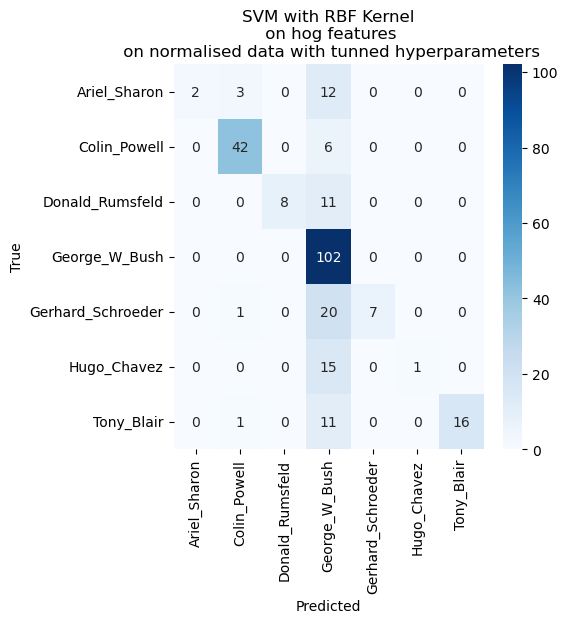

In [166]:
cm_svm_rbf_hog_n_tf = confusion_matrix(y_test_70, rbf_t_pred_y_70_f_hog)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_hog_n_tf, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_tunned_f_hog.classes_, yticklabels=svm_rbf_tunned_f_hog.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on hog features\n on normalised data with tunned hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

## LBP Features

In [167]:
X_train_70_df_lbp, X_test_70_df_lbp, y_train_70_lbp, y_test_70_lbp = train_test_split(X_lbp,y_70,train_size=0.8,random_state=42)
X_train_70_df_lbp.reset_index(drop=True, inplace = True)
X_test_70_df_lbp.reset_index(drop=True, inplace = True)
y_train_70_lbp.reset_index(drop=True, inplace = True)
y_test_70_lbp.reset_index(drop=True, inplace = True)

In [168]:
#Normalising the data
scaler_lbp=StandardScaler()
X_train_arr=X_train_70_df_lbp.values
X_test_arr=X_test_70_df_lbp.values
X_train_arr_n=scaler_lbp.fit_transform(X_train_arr)
joblib.dump(scaler_lbp,'Standard_Scalar_Normalisation_lbp_70.joblib')
X_test_arr_n = scaler_lbp.transform(X_test_arr)
X_train_70_lbp = pd.DataFrame(X_train_arr_n)
X_test_70_lbp = pd.DataFrame(X_test_arr_n)
# X_train_70_lbp

### LinearSVC

In [169]:
# Training Linear Support Vector Classifier (LinearSVC)
lin_clf_lbp = svm.LinearSVC(dual=False)
lin_clf_lbp.fit(X_train_70_lbp, y_train_70_lbp)
joblib.dump(lin_clf_lbp,'linearSVC_lbp_70.joblib')

['linearSVC_lbp_70.joblib']

In [170]:
pred_y_test_70_lbp = lin_clf_lbp.predict(X_test_70_lbp)

In [171]:
# Accuracy of linearSVC model
linSVC_accuracy = lin_clf_lbp.score(X_test_70_lbp, y_test_70_lbp)
print("Accuracy of linearSVC is ",linSVC_accuracy)

Accuracy of linearSVC is  0.32945736434108525


In [172]:
# Classification Report of linearSVC model
print(classification_report(y_test_70_lbp,pred_y_test_70_lbp))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.20      0.29      0.24        17
     Colin_Powell       0.42      0.27      0.33        48
  Donald_Rumsfeld       0.12      0.21      0.16        19
    George_W_Bush       0.50      0.46      0.48       102
Gerhard_Schroeder       0.19      0.18      0.18        28
      Hugo_Chavez       0.12      0.12      0.12        16
       Tony_Blair       0.28      0.32      0.30        28

         accuracy                           0.33       258
        macro avg       0.26      0.27      0.26       258
     weighted avg       0.36      0.33      0.34       258



Text(33.081597222222214, 0.5, 'True')

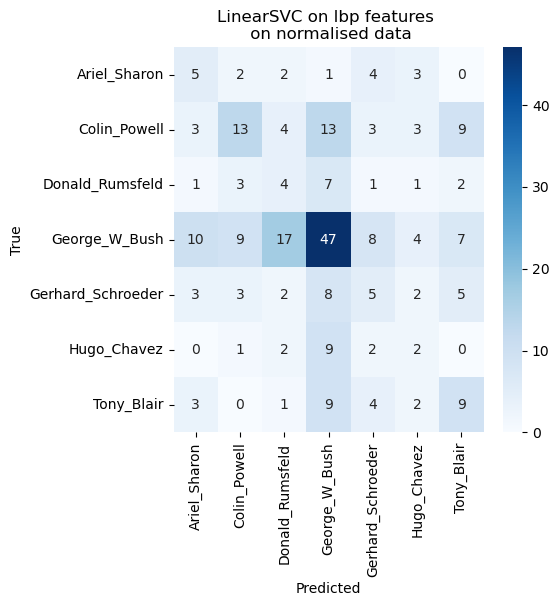

In [173]:
cm_linearSVC_lbp_n = confusion_matrix(y_test_70_lbp, pred_y_test_70_lbp)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_linearSVC_lbp_n, annot=True, fmt="d", cmap="Blues", xticklabels=lin_clf_lbp.classes_, yticklabels=lin_clf_lbp.classes_, ax=axes)
axes.set_title('LinearSVC on lbp features \n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

### SVM Models with Linear, polynomial and rbf kernals

In [174]:
svm_linear_lbp = SVC(kernel='linear') # linear kernal
svm_poly_lbp = SVC(kernel='poly', degree= 3)  # Polynomial kernel of degree 3
svm_rbf_lbp = SVC(kernel='rbf')  # RBF kernel

In [175]:
svm_linear_lbp.fit(X_train_70_lbp, y_train_70_lbp)
svm_poly_lbp.fit(X_train_70_lbp, y_train_70_lbp)
svm_rbf_lbp.fit(X_train_70_lbp, y_train_70_lbp)

SVC()

In [176]:
joblib.dump(svm_linear_lbp,'svm_linear_lbp_n_70.joblib')
joblib.dump(svm_poly_lbp,'svm_poly_lbp_n_70.joblib')
joblib.dump(svm_rbf_lbp,'svm_rbf_lbp_n_70.joblib')

['svm_rbf_lbp_n_70.joblib']

#### Linear Kernel

In [177]:
svm_linear_lbp.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [178]:
lin_pred_y_70_lbp = svm_linear_lbp.predict(X_test_70_lbp)

In [179]:
lin_accuracy_lbp = accuracy_score(y_test_70_lbp,lin_pred_y_70_lbp)
print("Accuracy of SVM with Linear kernel is ",lin_accuracy_lbp)

Accuracy of SVM with Linear kernel is  0.3023255813953488


In [180]:
print(classification_report(y_test_70_lbp,lin_pred_y_70_lbp))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.27      0.35      0.31        17
     Colin_Powell       0.31      0.33      0.32        48
  Donald_Rumsfeld       0.06      0.11      0.08        19
    George_W_Bush       0.46      0.44      0.45       102
Gerhard_Schroeder       0.05      0.04      0.04        28
      Hugo_Chavez       0.18      0.19      0.18        16
       Tony_Blair       0.26      0.18      0.21        28

         accuracy                           0.30       258
        macro avg       0.23      0.23      0.23       258
     weighted avg       0.31      0.30      0.30       258



Text(33.081597222222214, 0.5, 'True')

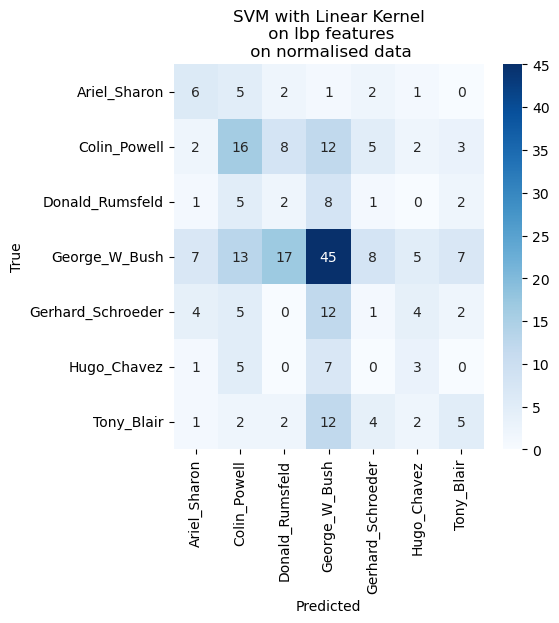

In [181]:
cm_svm_linear_lbp_n = confusion_matrix(y_test_70, lin_pred_y_70_lbp)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_linear_lbp_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_linear_lbp.classes_, yticklabels=svm_linear_lbp.classes_, ax=axes)
axes.set_title('SVM with Linear Kernel\n on lbp features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tunning Hyperparameter

In [182]:
c_values = [0.1, 1, 10, 100]

accuracy_values_lbp = []
predicted_values_lbp = []

for i in c_values:
    svm_lin_tunned_lbp = SVC(kernel='linear', C = i )
    svm_lin_tunned_lbp.fit(X_train_70_lbp, y_train_70_lbp)
    lin_t_pred_y_70_lbp = svm_lin_tunned_lbp.predict(X_test_70_lbp)
    lin_t_accuracy_lbp = accuracy_score(y_test_70_lbp,lin_t_pred_y_70_lbp)
    
    accuracy_values_lbp.append(lin_t_accuracy_lbp)
    predicted_values_lbp.append(lin_t_pred_y_70_lbp)
    
print(accuracy_values_lbp)

[0.35658914728682173, 0.3023255813953488, 0.3062015503875969, 0.3062015503875969]


Therefor, value of c (between 0.1 to 100) is not affecting the accuracy.
So, no requirement of hyperparameter tuning.

#### Polynomial Kernel

In [183]:
svm_poly_lbp.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [184]:
poly_pred_y_70_lbp = svm_poly_lbp.predict(X_test_70_lbp)

In [185]:
poly_accuracy_lbp = accuracy_score(y_test_70_lbp,poly_pred_y_70_lbp)
print("Accuracy of SVM with polynomial kernel (of degree 3) is ",poly_accuracy_lbp)

Accuracy of SVM with polynomial kernel (of degree 3) is  0.43023255813953487


In [186]:
print(classification_report(y_test_70_lbp,poly_pred_y_70_lbp))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.50      0.06      0.11        17
     Colin_Powell       0.67      0.17      0.27        48
  Donald_Rumsfeld       1.00      0.11      0.19        19
    George_W_Bush       0.42      0.98      0.59       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.00      0.00      0.00        28

         accuracy                           0.43       258
        macro avg       0.37      0.19      0.16       258
     weighted avg       0.40      0.43      0.30       258



Text(33.081597222222214, 0.5, 'True')

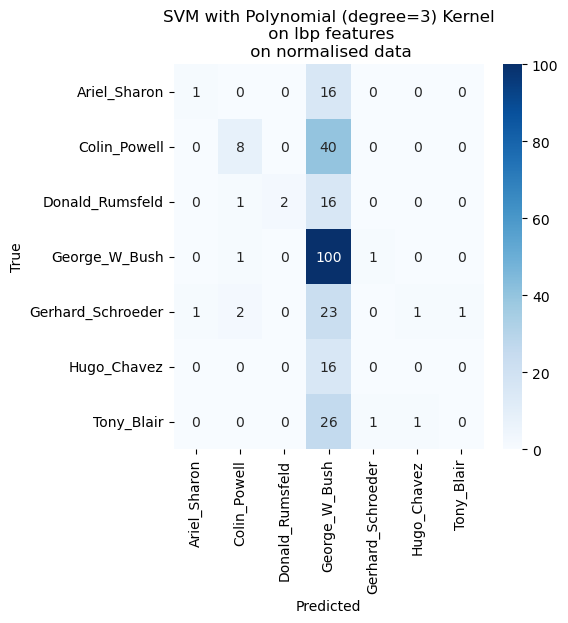

In [187]:
cm_svm_poly_lbp_n = confusion_matrix(y_test_70, poly_pred_y_70_lbp)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_lbp_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly_lbp.classes_, yticklabels=svm_poly_lbp.classes_, ax=axes)
axes.set_title('SVM with Polynomial (degree=3) Kernel\n on lbp features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tuning Hyperparameters

In [188]:
# Defining parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search_lbp_poly = GridSearchCV(estimator=svm_poly_lbp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lbp_poly.fit(X_train_70_lbp,y_train_70_lbp)

# Best parameters
poly_best_params_initial_lbp = grid_search_lbp_poly.best_params_
poly_best_params_initial_lbp

{'C': 1, 'gamma': 0.01}

In [189]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + grid_search_lbp_poly.cv_results_['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + grid_search_lbp_poly.cv_results_['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)

[0.4342233009708738, 0.43422330097087375, 0.43713592233009707, 0.4371359223300971]
[0.10388349514563107, 0.10388349514563107, 0.10388349514563107, 0.10388349514563107]


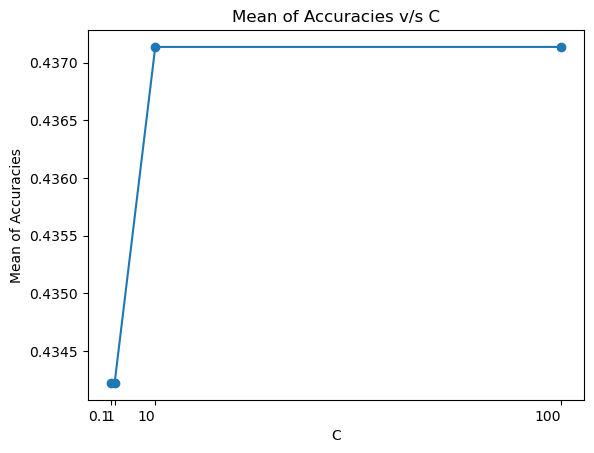

In [190]:
fig, ax = plt.subplots()
ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

plt.show()


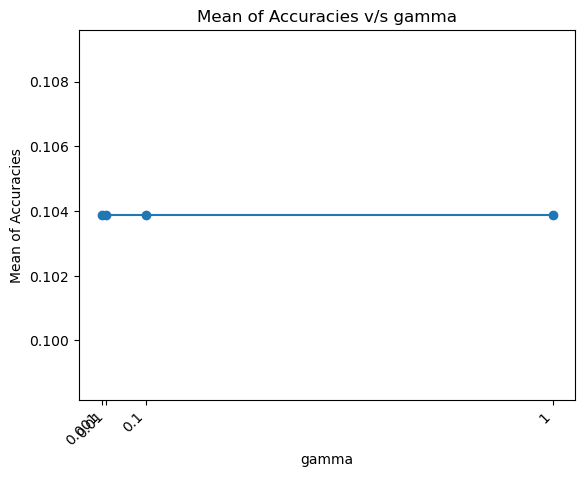

In [191]:
fig, ax = plt.subplots()
ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

plt.show()

In [192]:
svm_poly_tunned_lbp = SVC(kernel='poly', gamma=poly_best_params_initial_lbp['gamma'], C =poly_best_params_initial_lbp['C'] )
svm_poly_tunned_lbp.fit(X_train_70_lbp, y_train_70_lbp)

SVC(C=1, gamma=0.01, kernel='poly')

In [193]:
joblib.dump(svm_poly_tunned_lbp,'svm_poly_lbp_n_t_70.joblib')

['svm_poly_lbp_n_t_70.joblib']

In [194]:
poly_t_pred_y_70_lbp = svm_poly_tunned_lbp.predict(X_test_70_lbp)

In [195]:
poly_t_accuracy_lbp = accuracy_score(y_test_70_lbp,poly_t_pred_y_70_lbp)
print("Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is ",poly_t_accuracy_lbp)

Accuracy of SVM with Polynomial kernel (degree = 3) with tunned hyperparameters is  0.46124031007751937


In [196]:
print(classification_report(y_test_70_lbp,poly_t_pred_y_70_lbp))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.33      0.06      0.10        17
     Colin_Powell       0.53      0.40      0.45        48
  Donald_Rumsfeld       0.57      0.21      0.31        19
    George_W_Bush       0.47      0.90      0.62       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.25      0.11      0.15        28

         accuracy                           0.46       258
        macro avg       0.31      0.24      0.23       258
     weighted avg       0.38      0.46      0.37       258



Text(33.081597222222214, 0.5, 'True')

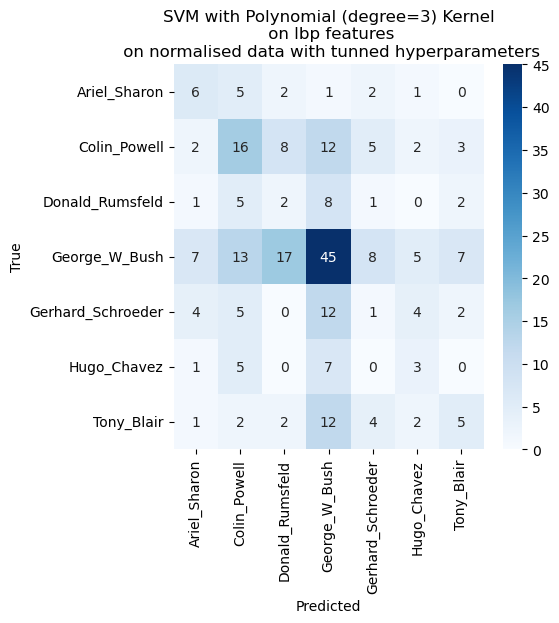

In [197]:
cm_svm_poly_lbp_n_t = confusion_matrix(y_test_70, lin_pred_y_70_lbp)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_poly_lbp_n_t, annot=True, fmt="d", cmap="Blues", xticklabels=svm_poly_tunned_lbp.classes_, yticklabels=svm_poly_tunned_lbp.classes_, ax=axes)
axes.set_title('SVM with Polynomial (degree=3) Kernel\n on lbp features\n on normalised data with tunned hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')


#### RBF Kernel

In [198]:
rbf_pred_y_70_lbp = svm_rbf_lbp.predict(X_test_70_lbp)

In [199]:
rbf_accuracy_lbp = accuracy_score(y_test_70_lbp,rbf_pred_y_70_lbp)
print("Accuracy of SVM with RBF kernel is ",rbf_accuracy_lbp)

Accuracy of SVM with RBF kernel is  0.43410852713178294


In [200]:
print(classification_report(y_test_70_lbp,rbf_pred_y_70_lbp))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        17
     Colin_Powell       0.44      0.29      0.35        48
  Donald_Rumsfeld       1.00      0.05      0.10        19
    George_W_Bush       0.43      0.95      0.59       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.00      0.00      0.00        28

         accuracy                           0.43       258
        macro avg       0.27      0.19      0.15       258
     weighted avg       0.33      0.43      0.31       258



C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bharm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(33.081597222222214, 0.5, 'True')

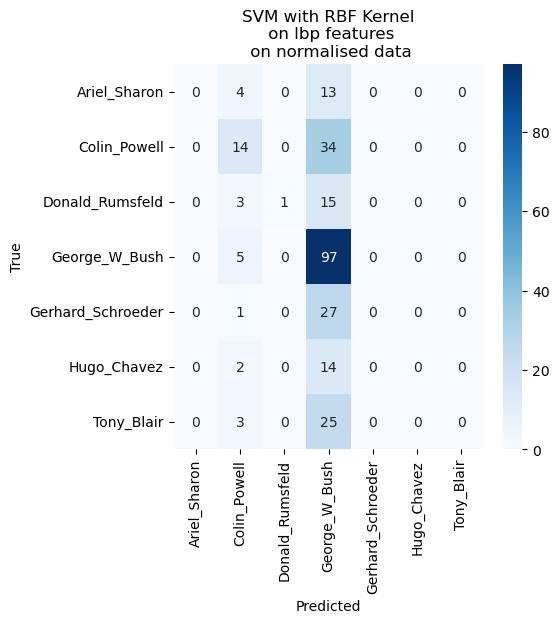

In [201]:
cm_svm_rbf_lbp_n = confusion_matrix(y_test_70, rbf_pred_y_70_lbp)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_lbp_n, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_lbp.classes_, yticklabels=svm_rbf_lbp.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on lbp features\n on normalised data')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

##### Tuning Hyperparameteres

In [202]:
# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Performing grid search
grid_search_lbp_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lbp_rbf.fit(X_train_70_lbp, y_train_70_lbp)

# Best parameters
rbf_best_params_initial_lbp = grid_search_lbp_rbf.best_params_
rbf_best_params_initial_lbp

{'C': 10, 'gamma': 0.001}

In [203]:
C_values = [0.1,1,10,100]
Gamma_values = [0.001,0.01,0.1,1]
mean_C = []
for i in range(len(C_values)):
    sum = 0
    for j in range(len(Gamma_values)):
        sum = sum + grid_search_lbp_rbf.cv_results_['mean_test_score'][i+j]
    mean_C.append(sum/len(Gamma_values))
print(mean_C)

mean_gamma = []
for i in range(len(Gamma_values)):
    sum = 0
    for j in range(len(C_values)):
        if (i+j)%len(Gamma_values) == 0:
            sum = sum + grid_search_lbp_rbf.cv_results_['mean_test_score'][i+j]
    mean_gamma.append(sum/len(C_values))
print(mean_gamma)

[0.4155339805825243, 0.41941747572815535, 0.42791262135922326, 0.4279126213592233]
[0.10388349514563107, 0.10776699029126213, 0.10776699029126213, 0.10776699029126213]


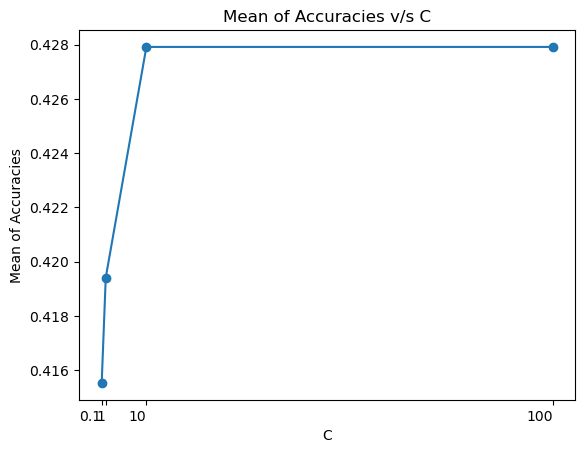

In [204]:
fig, ax = plt.subplots()
ax.plot(C_values, mean_C, marker='o', linestyle='-')
ax.set_xticks(C_values)
ax.set_xticklabels(C_values,ha='right')

ax.set_xlabel('C')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s C')

plt.show()

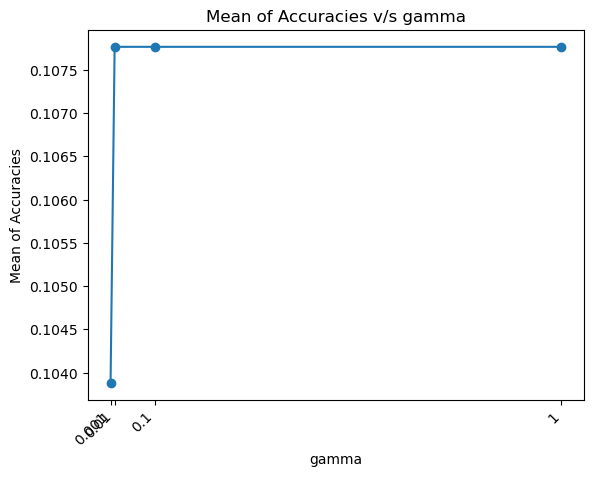

In [205]:
fig, ax = plt.subplots()
ax.plot(Gamma_values, mean_gamma, marker='o', linestyle='-')
ax.set_xticks(Gamma_values)
ax.set_xticklabels(Gamma_values, rotation=45 ,ha='right')

ax.set_xlabel('gamma')
ax.set_ylabel('Mean of Accuracies')
ax.set_title('Mean of Accuracies v/s gamma')

plt.show()

In [206]:
svm_rbf_tunned_lbp = SVC(kernel='rbf', gamma=rbf_best_params_initial_lbp['gamma'], C =rbf_best_params_initial_lbp['C'] )
svm_rbf_tunned_lbp.fit(X_train_70_lbp, y_train_70_lbp)

SVC(C=10, gamma=0.001)

In [207]:
joblib.dump(svm_rbf_tunned_lbp,'svm_rbf_lbp_n_ti_70.joblib')

['svm_rbf_lbp_n_ti_70.joblib']

In [208]:
rbf_t_pred_y_70_lbp = svm_rbf_tunned_lbp.predict(X_test_70_lbp)

In [209]:
rbf_t_accuracy_lbp = accuracy_score(y_test_70_lbp,rbf_t_pred_y_70_lbp)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy_lbp)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.45348837209302323


In [210]:
print(classification_report(y_test_70_lbp,rbf_t_pred_y_70_lbp))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.36      0.24      0.29        17
     Colin_Powell       0.39      0.48      0.43        48
  Donald_Rumsfeld       0.29      0.21      0.24        19
    George_W_Bush       0.51      0.72      0.60       102
Gerhard_Schroeder       0.17      0.04      0.06        28
      Hugo_Chavez       0.40      0.12      0.19        16
       Tony_Blair       0.50      0.36      0.42        28

         accuracy                           0.45       258
        macro avg       0.37      0.31      0.32       258
     weighted avg       0.42      0.45      0.42       258



In [211]:
# Defining the starting and ending points for C and gamma, and the number of points
start_C = 1
end_C = 100
num_C = 10

start_gamma = 0.001
end_gamma = 0.01
num_gamma = 5

# Parameter grid with specified ranges and number of points
param_grid = {'C': np.linspace(start_C, end_C, num_C),
              'gamma': np.linspace(start_gamma, end_gamma, num_gamma)}


# Performing grid search
grid_search_lbp_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5 , scoring='accuracy', n_jobs=-1)
grid_search_lbp_rbf.fit(X_train_70_lbp, y_train_70_lbp)

# Best parameters
rbf_best_params_final_lbp = grid_search_lbp_rbf.best_params_
rbf_best_accuracy_final_lbp = grid_search_lbp_rbf.best_score_
rbf_best_params_final_lbp

{'C': 12.0, 'gamma': 0.0032500000000000003}

In [212]:
svm_rbf_tunned_f_lbp = SVC(kernel='rbf', gamma=rbf_best_params_final_lbp['gamma'], C =rbf_best_params_final_lbp['C'] )
svm_rbf_tunned_f_lbp.fit(X_train_70_lbp, y_train_70_lbp)

SVC(C=12.0, gamma=0.0032500000000000003)

In [213]:
joblib.dump(svm_rbf_tunned_f_lbp,'svm_rbf_lbp_n_tf_70.joblib')

['svm_rbf_lbp_n_tf_70.joblib']

In [214]:
rbf_t_pred_y_70_f_lbp = svm_rbf_tunned_f_lbp.predict(X_test_70_lbp)

In [215]:
rbf_t_accuracy_f_lbp = accuracy_score(y_test_70_lbp,rbf_t_pred_y_70_f_lbp)
print("Accuracy of SVM with rbf kernel with tunned hyperparameters is ",rbf_t_accuracy_f_lbp)

Accuracy of SVM with rbf kernel with tunned hyperparameters is  0.4496124031007752


In [216]:
print(classification_report(y_test_70_lbp,rbf_t_pred_y_70_f_lbp))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.56      0.29      0.38        17
     Colin_Powell       0.38      0.50      0.43        48
  Donald_Rumsfeld       0.25      0.21      0.23        19
    George_W_Bush       0.52      0.73      0.60       102
Gerhard_Schroeder       0.00      0.00      0.00        28
      Hugo_Chavez       0.00      0.00      0.00        16
       Tony_Blair       0.50      0.32      0.39        28

         accuracy                           0.45       258
        macro avg       0.31      0.29      0.29       258
     weighted avg       0.38      0.45      0.40       258



Text(33.081597222222214, 0.5, 'True')

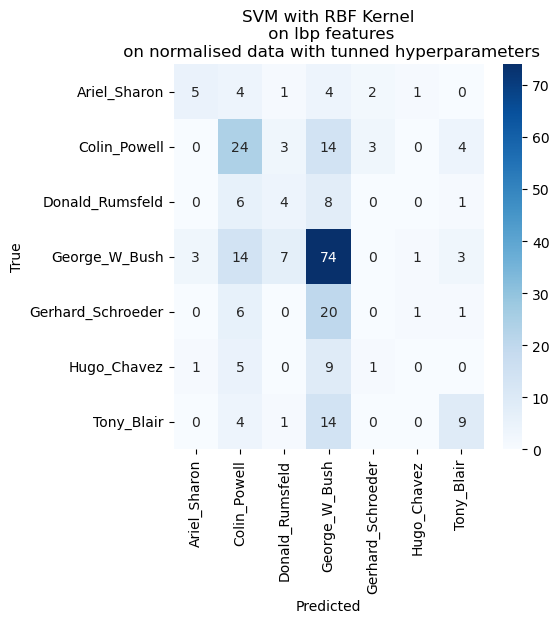

In [217]:
cm_svm_rbf_lbp_n_tf = confusion_matrix(y_test_70, rbf_t_pred_y_70_f_lbp)
fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm_rbf_lbp_n_tf, annot=True, fmt="d", cmap="Blues", xticklabels=svm_rbf_tunned_f_lbp.classes_, yticklabels=svm_rbf_tunned_f_lbp.classes_, ax=axes)
axes.set_title('SVM with RBF Kernel\n on lbp features\n on normalised data with tunned hyperparameters')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')